## Import Library

In [ ]:
#Install Ultralytics
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.4/750.4 kB 12.7 MB/s eta 0:00:00a 0:00:01


In [ ]:
!pip install roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.1/74.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 31.6 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.9.0.80
    Uninstalling opencv-python-headless-4.9.0.80:
      Successfully uninstalled opencv-python-headless-4.9.0.80
  Attempting uninstall: idna
    Found existing installation: idna 3.6
    Uninstalling idna-3.6:
      Successfully uninstalled idna-3.6
  Attempting uninstall: cycler
    Found existing installation: cycler 0.12.1
    Uninstalling cycler-0.12.1:
      Successfully uninstalled cycler-0.12.1
  Attempting uninstall: certifi
    Found existing installation: certifi 20

In [ ]:
import os
import yaml

from roboflow import Roboflow
from ultralytics import YOLO
from IPython.display import Image

# Dataset Preprocessing

#### The dataset consists of:
* Training Set: 5102
* Validation Set: 432
* Test Set: 21

Source:  https://universe.roboflow.com/plat-kendaraan/vehicle-and-license-plate/dataset/3

In [ ]:
rf = Roboflow(api_key="UHth3leRhT2RNziDnea7")
project = rf.workspace("plat-kendaraan").project("vehicle-and-license-plate")
version = project.version(3)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.1.47, to fix: `pip install ultralytics==8.0.196`



Extracting Dataset Version Zip to vehicle-and-license-plate-3 in yolov8:: 100%|██████████| 11122/11122 [00:01<00:00, 5832.56it/s]


#### Modify "data.yaml" that contains the class label and the path to the dataset.
#### The original format of the data.yaml is shown below:
 * train: ../train/images  --> Path to the training dataset
 * val: ../valid/images    --> Path to the validation dataset
 * test: ../test/images    --> Path to the testing dataset
 * nc: 4       --> Number of classes
 * names: ['License_Plate', 'cars', 'motorcyle', 'truck']  --> Clasess

#### Since our project objective is to detect the car plate, we will remove the irrelevant label and change the number of classes to 1.

In [ ]:
# Read the YAML file
file_path = "/kaggle/working/vehicle-and-license-plate-3/data.yaml"
with open(file_path, 'r') as yaml_file:
    yaml_data = yaml.safe_load(yaml_file)

# Modify the YAML data
yaml_data['test'] = '/kaggle/working/vehicle-and-license-plate-3/test/images'
yaml_data['train'] = '/kaggle/working/vehicle-and-license-plate-3/train/images'
yaml_data['val'] = '/kaggle/working/vehicle-and-license-plate-3/valid/images'

# Updating the number of classes to 1
yaml_data['nc'] = 1

# Updating the names list to only include 'License_Plate'
yaml_data['names'] = ['License_Plate']

# Write the modified YAML data back to the file
with open(file_path, 'w') as yaml_file:
    yaml.dump(yaml_data, yaml_file)

In [ ]:
# Read the YAML file
file_path = "/kaggle/working/vehicle-and-license-plate-3/data.yaml"
with open(file_path, 'r') as yaml_file:
    yaml_data = yaml.safe_load(yaml_file)


print(yaml_data)

{'names': ['License_Plate'], 'nc': 1, 'roboflow': {'license': 'MIT', 'project': 'vehicle-and-license-plate', 'url': 'https://universe.roboflow.com/plat-kendaraan/vehicle-and-license-plate/dataset/3', 'version': 3, 'workspace': 'plat-kendaraan'}, 'test': '/kaggle/working/vehicle-and-license-plate-3/test/images', 'train': '/kaggle/working/vehicle-and-license-plate-3/train/images', 'val': '/kaggle/working/vehicle-and-license-plate-3/valid/images'}


### Removing the irrelevant class label from the dataset's label and changing the annotation format to YOLO annotation format
YOLO Annotaiton format: class, x_center, y_center, width, height

In [ ]:
# This function is to auto update the updated annotation in YOLO format
def autoUpdate(sourcePath, annotationsCombo):
    # Open the file in write mode
    with open(sourcePath, 'w') as file2:
        ann = annotationsCombo

        for i, annotation in enumerate(ann):
            # Convert each annotation to a string
            line = ' '.join(map(str, annotation))

            # Write the line to the file
            file2.write(line)

            # If it's not the last line, add a newline character
            if i != len(annotations) - 1:
                file2.write('\n')

    return ann

In [ ]:
# Define the directories
directories = [
    "/kaggle/working/vehicle-and-license-plate-3/valid/labels",
    "/kaggle/working/vehicle-and-license-plate-3/test/labels",
    "/kaggle/working/vehicle-and-license-plate-3/train/labels"
]

# Iterate over each directory
for labelDirectory in directories:
    for fileName in os.listdir(labelDirectory):
        filePath = os.path.join(labelDirectory, fileName)

        # Annotations in YOLO format (class, x_center, y_center, width, height)
        annotations = []

        # Open the file and read its contents
        with open(filePath, 'r') as file:
            for line in file:
                # Split the line into a list of numbers
                numbers = [float(num) for num in line.strip().split()]

                # For the file that are not in YOLO format yet [class (x1 y1) (x2 y2) (x3 y3) (x4 y4) (x1 y1)]
                if (numbers[0] == 0 and len(numbers) > 5):
                    c = 0
                    all_x = [numbers[idx] for idx in range(1, len(numbers)-2, 2)]
                    all_y = [numbers[idx] for idx in range(2, len(numbers)-2, 2)]

                    x1 = min(all_x)
                    y1 = min(all_y)
                    x2 = max(all_x)
                    y2 = max(all_y)

                    x_center = (x1 + x2) / 2
                    y_center = (y1 + y2) / 2
                    width = x2 - x1
                    height = y2 - y1

                    annotations.append([c, x_center, y_center, width, height])

                # For the file that already in the YOLO format [class, x_center, y_center, width, height]
                if (numbers[0] == 0 and len(numbers) < 6):
                    numbers[0] = 0
                    annotations.append(numbers)

            annotations = autoUpdate(filePath, annotations)

### Helper function to freeze the layers

############################<br>
The following two function is adapted from https://github.com/ultralytics/ultralytics/issues/793
############################

In [ ]:
# Freeze the first 10 layers
def freezeLayer1(trainer):
    model = trainer.model
    num_freeze = 10

    # Layers that need to freeze
    freeze = [f'model.{x}.' for x in range(num_freeze)]
    for name, params in model.named_parameters():
        params.requires_grad = True
        if any(x in name for x in freeze):
            params.requires_grad = False

    for name, params in model.named_parameters():
        print(name, params.requires_grad)

In [ ]:
# Freeze the first 20 layers
def freezeLayer2(trainer):
    model = trainer.model
    num_freeze = 20

    # Layers that need to freeze
    freeze = [f'model.{x}.' for x in range(num_freeze)]
    for name, params in model.named_parameters():
        params.requires_grad = True
        if any(x in name for x in freeze):
            params.requires_grad = False

    for name, params in model.named_parameters():
        print(name, params.requires_grad)

# Fine-Tuning Pre-trained Model on Custom Dataset

#### Pre-train Model: Yolov8n
#### Evaluation Metrics:
1. mAP50   : Mean average precision for the intersection over union (IOU) that is over the threshold of 0.50.
2. mAP50-95: Mean average precision for the intersection over union (IOU) that is in the range from 0.50 to 0.95
#### The experiments conducted and the results are shown below:


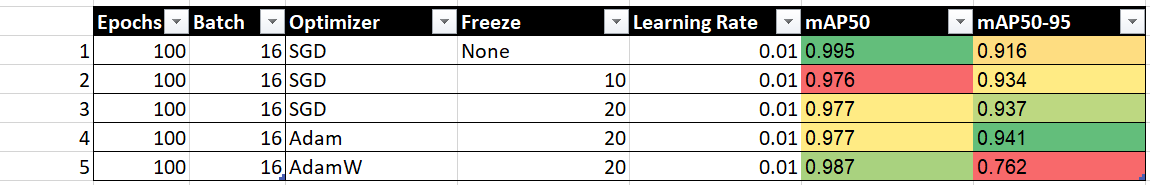

In [ ]:
os.environ['WANDB_MODE'] = 'disabled'

# Load the Model
model = YOLO("yolov8n.pt")

100%|██████████| 6.23M/6.23M [00:00<00:00, 74.5MB/s]


## Not Freezing Any Layers

In [ ]:
model.train(data="/kaggle/working/vehicle-and-license-plate-3/data.yaml", epochs=100, imgsz=640, optimizer="SGD")

Ultralytics YOLOv8.1.47 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/vehicle-and-license-plate-3/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_l

100%|██████████| 755k/755k [00:00<00:00, 21.6MB/s]
2024-04-16 09:30:05,074	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-04-16 09:30:06,659	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-04-16 09:30:09.237237: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-16 09:30:09.237348: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-16 09:30:09.379680: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS facto

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /kaggle/working/vehicle-and-license-plate-3/train/labels... 5102 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5102/5102 [00:03<00:00, 1353.71it/s]


train: New cache created: /kaggle/working/vehicle-and-license-plate-3/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/vehicle-and-license-plate-3/valid/labels... 432 images, 0 backgrounds, 0 corrupt: 100%|██████████| 432/432 [00:00<00:00, 1368.18it/s]

val: New cache created: /kaggle/working/vehicle-and-license-plate-3/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.36G      1.221      1.672      1.227         25        640: 100%|██████████| 319/319 [01:02<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.73it/s]

                   all        432        463      0.962      0.981      0.984      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.38G      1.142     0.8674      1.126         13        640: 100%|██████████| 319/319 [00:58<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.59it/s]

                   all        432        463      0.956      0.976      0.989      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.38G      1.158     0.8644      1.123         22        640: 100%|██████████| 319/319 [00:57<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.45it/s]

                   all        432        463      0.939      0.956       0.98      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.38G      1.175     0.8386      1.144         16        640: 100%|██████████| 319/319 [00:57<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.43it/s]

                   all        432        463      0.942       0.94      0.975      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.38G      1.159     0.7684      1.143         21        640: 100%|██████████| 319/319 [00:57<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.42it/s]

                   all        432        463      0.966      0.968      0.982      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.38G      1.121      0.717      1.127         25        640: 100%|██████████| 319/319 [00:57<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.50it/s]

                   all        432        463      0.953      0.971      0.976      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.38G      1.092     0.6731      1.116         24        640: 100%|██████████| 319/319 [00:57<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.68it/s]

                   all        432        463      0.949       0.97      0.975      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.38G       1.07     0.6522      1.104         17        640: 100%|██████████| 319/319 [00:57<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.23it/s]

                   all        432        463      0.959      0.976      0.989      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.38G      1.057     0.6288      1.106         16        640: 100%|██████████| 319/319 [00:56<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.61it/s]

                   all        432        463      0.965       0.97      0.991      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.38G      1.052     0.6166      1.109         21        640: 100%|██████████| 319/319 [00:57<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.47it/s]

                   all        432        463      0.984      0.968      0.991      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.38G      1.026     0.5953      1.092         24        640: 100%|██████████| 319/319 [00:57<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.51it/s]

                   all        432        463      0.959       0.97      0.986      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.38G      1.019     0.5851      1.091         25        640: 100%|██████████| 319/319 [00:57<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.59it/s]

                   all        432        463      0.982      0.987      0.992      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.38G      1.016     0.5674      1.088         22        640: 100%|██████████| 319/319 [00:57<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.43it/s]

                   all        432        463       0.98      0.974      0.989      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.38G      0.993     0.5535       1.08         22        640: 100%|██████████| 319/319 [00:57<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.54it/s]

                   all        432        463      0.973      0.978      0.991      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.38G     0.9889     0.5482      1.077         22        640: 100%|██████████| 319/319 [00:57<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.59it/s]

                   all        432        463      0.981      0.986      0.993      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.38G     0.9764      0.535      1.072         25        640: 100%|██████████| 319/319 [00:57<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.53it/s]

                   all        432        463      0.987      0.985      0.994      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.38G     0.9789     0.5379      1.076         17        640: 100%|██████████| 319/319 [00:56<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.12it/s]

                   all        432        463       0.98      0.991      0.991       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.38G     0.9548     0.5235       1.06         21        640: 100%|██████████| 319/319 [00:56<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.63it/s]

                   all        432        463      0.978      0.987      0.992      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.38G     0.9464     0.5141      1.057         25        640: 100%|██████████| 319/319 [00:57<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.62it/s]

                   all        432        463      0.985      0.985      0.992      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.38G     0.9467     0.5145      1.058         26        640: 100%|██████████| 319/319 [00:57<00:00,  5.56it/s]
     21/100      2.38G     0.9315     0.5006      1.057         29        640: 100%|██████████| 319/319 [00:57<00:00,  5.58it/s].83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.74it/s]

                   all        432        463      0.985      0.985      0.992      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.39G     0.9224     0.4938      1.051         15        640: 100%|██████████| 319/319 [00:57<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.72it/s]

                   all        432        463      0.983      0.987      0.993      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.38G     0.9102     0.4903      1.036         24        640: 100%|██████████| 319/319 [00:57<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.54it/s]

                   all        432        463      0.976      0.987      0.992      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.38G     0.9074     0.4839      1.039         29        640: 100%|██████████| 319/319 [00:57<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.68it/s]

                   all        432        463      0.983      0.972      0.991      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.38G     0.8999     0.4837       1.04         19        640: 100%|██████████| 319/319 [00:57<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.71it/s]

                   all        432        463      0.991      0.988      0.994      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.38G     0.8876     0.4695      1.031         22        640: 100%|██████████| 319/319 [00:57<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.32it/s]

                   all        432        463      0.991      0.989      0.993        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.38G     0.8728     0.4654      1.028         17        640: 100%|██████████| 319/319 [00:57<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.58it/s]

                   all        432        463      0.979      0.988      0.992      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.38G     0.8786     0.4634      1.023         17        640: 100%|██████████| 319/319 [00:57<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.60it/s]

                   all        432        463      0.991      0.985      0.993        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.38G     0.8704     0.4615      1.024         20        640: 100%|██████████| 319/319 [00:57<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.64it/s]

                   all        432        463      0.989      0.985      0.993      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.38G     0.8679     0.4635      1.023         25        640: 100%|██████████| 319/319 [00:57<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.56it/s]

                   all        432        463      0.977      0.987      0.992      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.38G     0.8505     0.4467      1.014         15        640: 100%|██████████| 319/319 [00:57<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.80it/s]

                   all        432        463      0.982      0.991      0.993      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.38G      0.841     0.4394      1.008         21        640: 100%|██████████| 319/319 [00:57<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.59it/s]

                   all        432        463      0.985      0.986      0.994      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.38G     0.8382     0.4387      1.007         23        640: 100%|██████████| 319/319 [00:57<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.60it/s]

                   all        432        463      0.983      0.988      0.991      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.38G     0.8268     0.4327      1.001         22        640: 100%|██████████| 319/319 [00:57<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.71it/s]

                   all        432        463      0.994      0.993      0.993      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.38G     0.8175       0.43      1.001         26        640: 100%|██████████| 319/319 [00:57<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.54it/s]

                   all        432        463      0.991      0.983      0.994      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.38G     0.8181     0.4321      1.001         30        640: 100%|██████████| 319/319 [00:57<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.79it/s]

                   all        432        463      0.987      0.989      0.993      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.39G     0.8107     0.4263     0.9935         15        640: 100%|██████████| 319/319 [00:57<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.60it/s]

                   all        432        463      0.981       0.99      0.993      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.38G      0.803     0.4179     0.9893         25        640: 100%|██████████| 319/319 [00:57<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.49it/s]

                   all        432        463      0.985      0.987      0.992      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.38G     0.7926     0.4147     0.9921         24        640: 100%|██████████| 319/319 [00:57<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.77it/s]

                   all        432        463      0.993      0.989      0.994      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.38G     0.7926     0.4157     0.9929         22        640: 100%|██████████| 319/319 [00:57<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.76it/s]

                   all        432        463      0.989       0.99      0.995      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.38G     0.7845     0.4093     0.9864         23        640: 100%|██████████| 319/319 [00:57<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.63it/s]

                   all        432        463      0.985      0.985      0.993      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.38G     0.7775     0.4045     0.9841         26        640: 100%|██████████| 319/319 [00:57<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.64it/s]

                   all        432        463      0.984      0.987      0.992       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.38G     0.7721     0.4035     0.9834         10        640: 100%|██████████| 319/319 [00:57<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.60it/s]

                   all        432        463      0.993      0.989      0.994      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.39G       0.76     0.3941     0.9766         19        640: 100%|██████████| 319/319 [00:57<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.46it/s]

                   all        432        463      0.987      0.987      0.992      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.38G     0.7575      0.398     0.9845         26        640: 100%|██████████| 319/319 [00:57<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.60it/s]

                   all        432        463      0.991      0.991      0.993      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.38G     0.7562     0.3931     0.9769         22        640: 100%|██████████| 319/319 [00:57<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.68it/s]

                   all        432        463      0.989      0.983      0.994      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.38G     0.7548     0.3886     0.9761         16        640: 100%|██████████| 319/319 [00:57<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.64it/s]

                   all        432        463      0.988      0.987      0.993      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.38G     0.7437     0.3859     0.9664         23        640: 100%|██████████| 319/319 [00:57<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.41it/s]

                   all        432        463      0.988      0.994      0.993      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.38G     0.7304     0.3847      0.963         15        640: 100%|██████████| 319/319 [00:57<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.47it/s]

                   all        432        463      0.989      0.987      0.994      0.849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.38G     0.7314     0.3826     0.9695         22        640: 100%|██████████| 319/319 [00:57<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.52it/s]

                   all        432        463      0.994      0.989      0.993      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.38G      0.728     0.3802     0.9681         21        640: 100%|██████████| 319/319 [00:57<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.64it/s]

                   all        432        463      0.991      0.987      0.994      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.38G     0.7161     0.3726     0.9585         22        640: 100%|██████████| 319/319 [00:57<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.65it/s]

                   all        432        463      0.989      0.989      0.993      0.851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.38G     0.7133     0.3711      0.949         22        640: 100%|██████████| 319/319 [00:57<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.52it/s]

                   all        432        463      0.979      0.995      0.993      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.38G      0.701     0.3709     0.9532         35        640: 100%|██████████| 319/319 [00:57<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.21it/s]

                   all        432        463      0.991      0.989      0.993      0.858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.38G     0.7053     0.3671     0.9532         26        640: 100%|██████████| 319/319 [00:57<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.54it/s]

                   all        432        463      0.989      0.989      0.994      0.861



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.38G     0.6868     0.3578     0.9421         15        640: 100%|██████████| 319/319 [00:57<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.53it/s]

                   all        432        463      0.989      0.992      0.994      0.864



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.38G     0.6785     0.3587     0.9449         27        640: 100%|██████████| 319/319 [00:57<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.63it/s]

                   all        432        463      0.989      0.991      0.991      0.857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.38G     0.6768     0.3564     0.9386         26        640: 100%|██████████| 319/319 [00:57<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.45it/s]

                   all        432        463      0.991      0.991      0.994      0.849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.38G     0.6757     0.3501     0.9378         28        640: 100%|██████████| 319/319 [00:57<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.63it/s]

                   all        432        463      0.991      0.989      0.994      0.865



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.38G     0.6762     0.3557      0.942         21        640: 100%|██████████| 319/319 [00:57<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.68it/s]

                   all        432        463      0.991      0.991      0.994      0.861



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.38G      0.671     0.3516     0.9394         15        640: 100%|██████████| 319/319 [00:57<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.48it/s]

                   all        432        463      0.989      0.992      0.994      0.861



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.38G     0.6732     0.3499     0.9419         27        640: 100%|██████████| 319/319 [00:57<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.40it/s]

                   all        432        463      0.989      0.996      0.993      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.38G     0.6518     0.3424     0.9377         19        640: 100%|██████████| 319/319 [00:57<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.35it/s]

                   all        432        463       0.99      0.994      0.994      0.871



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.38G     0.6601     0.3425      0.937         22        640: 100%|██████████| 319/319 [00:57<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.33it/s]

                   all        432        463      0.985      0.994      0.995      0.875



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.38G     0.6461     0.3385      0.927         16        640: 100%|██████████| 319/319 [00:57<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.41it/s]

                   all        432        463      0.987      0.996      0.993       0.87



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.38G      0.643     0.3384     0.9218         17        640: 100%|██████████| 319/319 [00:57<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.44it/s]

                   all        432        463      0.986      0.994      0.994      0.869



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.38G      0.644     0.3381     0.9306         26        640: 100%|██████████| 319/319 [00:57<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.64it/s]

                   all        432        463      0.992      0.994      0.994       0.88



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.38G     0.6321     0.3322     0.9235         25        640: 100%|██████████| 319/319 [00:57<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.77it/s]

                   all        432        463      0.989      0.994      0.995      0.873



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.38G     0.6217     0.3276     0.9169         16        640: 100%|██████████| 319/319 [00:57<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.36it/s]

                   all        432        463      0.991      0.995      0.995      0.868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.38G     0.6238     0.3263     0.9163         20        640: 100%|██████████| 319/319 [00:57<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.57it/s]

                   all        432        463      0.991      0.996      0.994       0.87



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.38G     0.6223      0.325     0.9201         24        640: 100%|██████████| 319/319 [00:57<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.57it/s]

                   all        432        463      0.987      0.994      0.994      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.38G     0.6164     0.3226     0.9175         21        640: 100%|██████████| 319/319 [00:57<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.62it/s]

                   all        432        463      0.991      0.994      0.994      0.872



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.38G     0.6058      0.322     0.9089         25        640: 100%|██████████| 319/319 [00:57<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.53it/s]

                   all        432        463      0.991      0.993      0.993       0.88



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.38G     0.6044     0.3183     0.9073         27        640: 100%|██████████| 319/319 [00:57<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.64it/s]

                   all        432        463      0.991      0.991      0.994      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.38G     0.6006     0.3178     0.9131         16        640: 100%|██████████| 319/319 [00:57<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.97it/s]

                   all        432        463      0.991      0.994      0.994      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.38G     0.5949     0.3124       0.91         21        640: 100%|██████████| 319/319 [00:57<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.59it/s]

                   all        432        463      0.988      0.991      0.994      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.38G     0.5879     0.3085     0.9049         20        640: 100%|██████████| 319/319 [00:57<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.59it/s]

                   all        432        463      0.991      0.991      0.994      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.38G     0.5801      0.307     0.9041         22        640: 100%|██████████| 319/319 [00:57<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.63it/s]

                   all        432        463      0.991      0.991      0.995      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.38G     0.5786     0.3043     0.9052         27        640: 100%|██████████| 319/319 [00:57<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.66it/s]

                   all        432        463      0.991      0.993      0.995      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.38G     0.5733     0.3028     0.9009         18        640: 100%|██████████| 319/319 [00:57<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.58it/s]

                   all        432        463      0.991      0.994      0.994       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.38G     0.5694     0.3032     0.8957         19        640: 100%|██████████| 319/319 [00:57<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.57it/s]

                   all        432        463      0.991      0.991      0.995      0.888



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.38G      0.566     0.2995     0.8963         20        640: 100%|██████████| 319/319 [00:57<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.63it/s]

                   all        432        463      0.991      0.994      0.994      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.38G     0.5639     0.2969     0.8983         19        640: 100%|██████████| 319/319 [00:57<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.57it/s]

                   all        432        463      0.991      0.994      0.994      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.38G     0.5631     0.2977     0.8983         16        640: 100%|██████████| 319/319 [00:57<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.57it/s]

                   all        432        463      0.991      0.994      0.994       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.38G     0.5545     0.2951     0.8928         17        640: 100%|██████████| 319/319 [00:57<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.09it/s]

                   all        432        463       0.99      0.994      0.995      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.38G      0.551     0.2913     0.8938         24        640: 100%|██████████| 319/319 [00:57<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.52it/s]

                   all        432        463      0.992      0.994      0.995      0.896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.38G     0.5417     0.2865     0.8914         25        640: 100%|██████████| 319/319 [00:57<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.51it/s]

                   all        432        463      0.991      0.991      0.995      0.896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.38G       0.54     0.2844     0.8867         21        640: 100%|██████████| 319/319 [00:57<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.57it/s]

                   all        432        463      0.991      0.994      0.995      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.38G     0.5353     0.2845     0.8839         24        640: 100%|██████████| 319/319 [00:57<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.52it/s]

                   all        432        463      0.991      0.994      0.994      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.38G     0.5351     0.2852     0.8827         23        640: 100%|██████████| 319/319 [00:57<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.53it/s]

                   all        432        463       0.99      0.994      0.994      0.895


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.38G     0.4828     0.2363     0.8532         14        640: 100%|██████████| 319/319 [00:58<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.42it/s]

                   all        432        463      0.991      0.994      0.994      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.38G     0.4619     0.2298     0.8503         14        640: 100%|██████████| 319/319 [00:56<00:00,  5.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.57it/s]

                   all        432        463      0.991      0.991      0.994      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.39G     0.4596     0.2277     0.8444         15        640: 100%|██████████| 319/319 [00:56<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.65it/s]

                   all        432        463      0.987      0.994      0.994      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.39G      0.448     0.2231     0.8435         16        640: 100%|██████████| 319/319 [00:56<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.70it/s]

                   all        432        463      0.991      0.991      0.994      0.896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.38G     0.4452     0.2226     0.8353         16        640: 100%|██████████| 319/319 [00:56<00:00,  5.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.17it/s]

                   all        432        463      0.991      0.994      0.994      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.38G     0.4389      0.219     0.8355         14        640: 100%|██████████| 319/319 [00:56<00:00,  5.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.66it/s]

                   all        432        463      0.993      0.989      0.994      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.39G     0.4316     0.2161     0.8326         15        640: 100%|██████████| 319/319 [00:56<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.51it/s]

                   all        432        463      0.993      0.989      0.994      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.38G     0.4254     0.2133     0.8361         14        640: 100%|██████████| 319/319 [00:56<00:00,  5.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.62it/s]

                   all        432        463      0.993      0.989      0.994        0.9



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.38G     0.4231     0.2105     0.8311         14        640: 100%|██████████| 319/319 [00:56<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.49it/s]

                   all        432        463      0.993      0.988      0.994        0.9



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.39G     0.4204     0.2096     0.8326         15        640: 100%|██████████| 319/319 [00:56<00:00,  5.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.66it/s]

                   all        432        463      0.993      0.988      0.994      0.898



100 epochs completed in 1.683 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.3MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.1.47 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.13it/s]


                   all        432        463      0.993      0.989      0.994      0.903
Speed: 0.2ms preprocess, 2.0ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d1adc3bfe80>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

### Validation Result during Training

In [ ]:
model = YOLO("/kaggle/working/runs/detect/train/weights/best.pt")
result = model.val(data="/kaggle/working/vehicle-and-license-plate-3/data.yaml")

Ultralytics YOLOv8.1.47 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /kaggle/working/vehicle-and-license-plate-3/valid/labels.cache... 432 images, 0 backgrounds, 0 corrupt: 100%|██████████| 432/432 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:04<00:00,  5.60it/s]


                   all        432        463      0.993      0.989      0.994      0.903
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/detect/val13


### Validate on Testing Dataset

In [ ]:
model = YOLO("/kaggle/working/runs/detect/train/weights/best.pt")
result = model.val(data="/kaggle/working/vehicle-and-license-plate-3/data.yaml", split="test")

Ultralytics YOLOv8.1.47 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /kaggle/working/vehicle-and-license-plate-3/test/labels.cache... 21 images, 0 backgrounds, 0 corrupt: 100%|██████████| 21/21 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.21it/s]


                   all         21         23          1          1      0.995      0.916
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/val14


## Freeze first 10 layers

In [ ]:
model = YOLO("yolov8n.pt")

# Add the callback event to freeze the layers
model.add_callback("on_train_start", freezeLayer1)
model.train(data="/kaggle/working/vehicle-and-license-plate-3/data.yaml", epochs=100, imgsz=640, optimizer="SGD")

Ultralytics YOLOv8.1.47 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/vehicle-and-license-plate-3/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_

train: Scanning /kaggle/working/vehicle-and-license-plate-3/train/labels.cache... 5102 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5102/5102 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/vehicle-and-license-plate-3/valid/labels.cache... 432 images, 0 backgrounds, 0 corrupt: 100%|██████████| 432/432 [00:00<?, ?it/s]


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
model.0.conv.weight False
model.0.bn.weight False
model.0.bn.bias False
model.1.conv.weight False
model.1.bn.weight False
model.1.bn.bias False
model.2.cv1.conv.weight False
model.2.cv1.bn.weight False
model.2.cv1.bn.bias False
model.2.cv2.conv.weight False
model.2.cv2.bn.weight False
model.2.cv2.bn.bias False
model.2.m.0.cv1.conv.weight False
model.2.m.0.cv1.bn.weight False
model.2.m.0.cv1.bn.bias False
model.2.m.0.cv2.conv.weight False
model.2.m.0.cv2.bn.weight False
model.2.m.0.cv2.bn.bias False
model.3.conv.weight False
model.3.bn.weight False
model.3.bn.bias False
model.4.cv1.conv.weight False
model.4.cv1.bn.weight False
model.4.cv1.bn.bias False
model.4.cv2.conv.weight False
model.4.cv2.bn.weight False
model.4.cv2.bn.bias False
model.4.m.0.cv1.conv.weight 

      1/100      1.48G     0.4447     0.2318     0.8445         13        640: 100%|██████████| 319/319 [00:46<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.67it/s]

                   all        432        463      0.993      0.989      0.995      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      1.16G     0.4758       0.26     0.8527         15        640: 100%|██████████| 319/319 [00:44<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.47it/s]

                   all        432        463      0.991      0.993      0.994      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      1.14G     0.5108     0.2919     0.8688         14        640: 100%|██████████| 319/319 [00:44<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.85it/s]

                   all        432        463      0.996      0.987      0.993      0.877



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      1.14G     0.5406     0.3129     0.8807         14        640: 100%|██████████| 319/319 [00:43<00:00,  7.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.55it/s]

                   all        432        463      0.992      0.991      0.992      0.873



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      1.12G     0.5317     0.3187       0.89         14        640: 100%|██████████| 319/319 [00:44<00:00,  7.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.57it/s]

                   all        432        463      0.989      0.991      0.992      0.863



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      1.12G     0.5256     0.3142     0.8822         14        640: 100%|██████████| 319/319 [00:43<00:00,  7.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.43it/s]

                   all        432        463      0.994      0.991      0.993      0.873



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      1.12G     0.5239      0.306     0.8854         14        640: 100%|██████████| 319/319 [00:44<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.72it/s]

                   all        432        463      0.989      0.994      0.994      0.866



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      1.12G     0.5141     0.3023     0.8819         15        640: 100%|██████████| 319/319 [00:44<00:00,  7.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.70it/s]

                   all        432        463      0.993      0.994      0.992      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      1.12G     0.5219     0.3006     0.8826         18        640: 100%|██████████| 319/319 [00:44<00:00,  7.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.72it/s]

                   all        432        463      0.993      0.994      0.994      0.872



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      1.12G     0.5125     0.2997      0.874         18        640: 100%|██████████| 319/319 [00:43<00:00,  7.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.70it/s]

                   all        432        463      0.991      0.994      0.992       0.88



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      1.12G      0.506      0.294      0.876         14        640: 100%|██████████| 319/319 [00:44<00:00,  7.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.22it/s]

                   all        432        463      0.989      0.989      0.993      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      1.12G     0.5109     0.2928     0.8711         16        640: 100%|██████████| 319/319 [00:43<00:00,  7.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.62it/s]

                   all        432        463      0.994      0.991      0.994      0.876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      1.12G     0.5078     0.2944     0.8722         15        640: 100%|██████████| 319/319 [00:43<00:00,  7.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.22it/s]

                   all        432        463      0.993      0.994      0.992      0.873



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      1.12G     0.5031     0.2934     0.8736         14        640: 100%|██████████| 319/319 [00:43<00:00,  7.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.64it/s]

                   all        432        463      0.993      0.994      0.994      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      1.12G     0.4995     0.2869     0.8743         15        640: 100%|██████████| 319/319 [00:43<00:00,  7.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.62it/s]

                   all        432        463      0.996      0.989      0.994      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      1.12G     0.4952     0.2836     0.8726         14        640: 100%|██████████| 319/319 [00:44<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.69it/s]

                   all        432        463      0.993      0.989      0.994      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      1.12G      0.494     0.2812     0.8718         14        640: 100%|██████████| 319/319 [00:43<00:00,  7.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.69it/s]

                   all        432        463      0.994      0.993      0.994       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      1.12G     0.4924     0.2839     0.8636         15        640: 100%|██████████| 319/319 [00:43<00:00,  7.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.71it/s]

                   all        432        463      0.991      0.991      0.994      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      1.12G     0.4924      0.284     0.8741         15        640: 100%|██████████| 319/319 [00:43<00:00,  7.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.66it/s]

                   all        432        463      0.991      0.995      0.994      0.874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      1.12G     0.4874     0.2775      0.865         15        640: 100%|██████████| 319/319 [00:44<00:00,  7.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.51it/s]

                   all        432        463      0.992      0.991      0.993      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      1.12G     0.4848     0.2756     0.8608         15        640: 100%|██████████| 319/319 [00:43<00:00,  7.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.33it/s]

                   all        432        463      0.989      0.994      0.993      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      1.12G     0.4896     0.2777     0.8676         13        640: 100%|██████████| 319/319 [00:44<00:00,  7.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.60it/s]

                   all        432        463       0.99      0.991      0.994      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      1.12G     0.4818     0.2757     0.8726         14        640: 100%|██████████| 319/319 [00:44<00:00,  7.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.69it/s]

                   all        432        463      0.994      0.993      0.992      0.887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      1.12G     0.4775     0.2692     0.8655         14        640: 100%|██████████| 319/319 [00:44<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.57it/s]

                   all        432        463      0.993      0.994      0.992      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      1.12G       0.48     0.2722     0.8664         14        640: 100%|██████████| 319/319 [00:43<00:00,  7.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.60it/s]

                   all        432        463      0.993      0.991      0.993      0.875



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      1.12G     0.4747     0.2713     0.8628         16        640: 100%|██████████| 319/319 [00:44<00:00,  7.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.38it/s]

                   all        432        463      0.994      0.993      0.993      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      1.12G     0.4768     0.2688     0.8674         14        640: 100%|██████████| 319/319 [00:43<00:00,  7.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.71it/s]

                   all        432        463      0.993      0.994      0.994      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      1.12G     0.4773     0.2673     0.8627         15        640: 100%|██████████| 319/319 [00:44<00:00,  7.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.26it/s]

                   all        432        463      0.991      0.994      0.993      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      1.12G     0.4745     0.2668     0.8644         16        640: 100%|██████████| 319/319 [00:43<00:00,  7.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.58it/s]

                   all        432        463      0.993      0.989      0.993      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      1.12G      0.465     0.2606     0.8574         16        640: 100%|██████████| 319/319 [00:43<00:00,  7.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.56it/s]

                   all        432        463      0.991      0.993      0.992      0.888



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      1.12G     0.4674     0.2625     0.8589         16        640: 100%|██████████| 319/319 [00:43<00:00,  7.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.66it/s]

                   all        432        463      0.991      0.993      0.993      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      1.12G     0.4675     0.2602      0.856         15        640: 100%|██████████| 319/319 [00:43<00:00,  7.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.82it/s]

                   all        432        463      0.994      0.993      0.993       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      1.12G     0.4672     0.2634     0.8596         15        640: 100%|██████████| 319/319 [00:44<00:00,  7.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.64it/s]

                   all        432        463      0.993      0.991      0.993      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      1.12G     0.4671     0.2612     0.8579         15        640: 100%|██████████| 319/319 [00:43<00:00,  7.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.67it/s]

                   all        432        463      0.993      0.991      0.993      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      1.12G       0.46     0.2554     0.8497         14        640: 100%|██████████| 319/319 [00:44<00:00,  7.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.56it/s]

                   all        432        463      0.996      0.993      0.993      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      1.12G     0.4594     0.2549     0.8543         15        640: 100%|██████████| 319/319 [00:43<00:00,  7.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.90it/s]

                   all        432        463      0.994      0.995      0.993      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      1.12G     0.4635     0.2551     0.8522         14        640: 100%|██████████| 319/319 [00:43<00:00,  7.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.52it/s]

                   all        432        463      0.994      0.996      0.994      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      1.12G     0.4644     0.2545     0.8515         14        640: 100%|██████████| 319/319 [00:43<00:00,  7.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.67it/s]

                   all        432        463      0.993      0.994      0.992      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      1.12G     0.4646     0.2535     0.8477         15        640: 100%|██████████| 319/319 [00:44<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.61it/s]

                   all        432        463      0.992      0.991      0.993      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      1.12G     0.4563       0.25     0.8494         14        640: 100%|██████████| 319/319 [00:43<00:00,  7.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.54it/s]

                   all        432        463      0.991      0.996      0.993      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      1.12G     0.4528     0.2468     0.8456         14        640: 100%|██████████| 319/319 [00:43<00:00,  7.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.23it/s]

                   all        432        463      0.993      0.991      0.994      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      1.12G     0.4522     0.2499     0.8474         14        640: 100%|██████████| 319/319 [00:43<00:00,  7.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.66it/s]

                   all        432        463      0.993      0.994      0.994      0.896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      1.12G     0.4518     0.2468     0.8549         15        640: 100%|██████████| 319/319 [00:43<00:00,  7.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.08it/s]

                   all        432        463      0.994      0.993      0.992      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      1.12G     0.4524     0.2488     0.8486         14        640: 100%|██████████| 319/319 [00:43<00:00,  7.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.84it/s]

                   all        432        463      0.993      0.991      0.993       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      1.12G     0.4486     0.2449     0.8492         17        640: 100%|██████████| 319/319 [00:43<00:00,  7.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.90it/s]

                   all        432        463      0.991      0.993      0.994      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      1.12G     0.4462     0.2445     0.8518         14        640: 100%|██████████| 319/319 [00:43<00:00,  7.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.65it/s]

                   all        432        463      0.994      0.991      0.993      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      1.12G     0.4447     0.2461      0.846         14        640: 100%|██████████| 319/319 [00:43<00:00,  7.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.83it/s]

                   all        432        463      0.993      0.994      0.994      0.897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      1.12G     0.4472     0.2441     0.8458         14        640: 100%|██████████| 319/319 [00:44<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.87it/s]

                   all        432        463      0.993      0.991      0.994      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      1.12G     0.4424     0.2422      0.846         14        640: 100%|██████████| 319/319 [00:43<00:00,  7.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.60it/s]

                   all        432        463      0.994      0.993      0.994        0.9



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      1.12G     0.4399     0.2415     0.8444         15        640: 100%|██████████| 319/319 [00:44<00:00,  7.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.68it/s]

                   all        432        463      0.991      0.996      0.994      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      1.12G      0.438     0.2397      0.843         14        640: 100%|██████████| 319/319 [00:43<00:00,  7.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.53it/s]

                   all        432        463      0.993      0.991      0.993      0.897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      1.12G     0.4414     0.2399     0.8458         15        640: 100%|██████████| 319/319 [00:44<00:00,  7.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.60it/s]

                   all        432        463      0.991      0.994      0.993      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      1.12G     0.4354     0.2361     0.8432         15        640: 100%|██████████| 319/319 [00:43<00:00,  7.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.58it/s]

                   all        432        463      0.991      0.991      0.994      0.896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      1.12G     0.4343     0.2363     0.8421         15        640: 100%|██████████| 319/319 [00:43<00:00,  7.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.02it/s]

                   all        432        463      0.993      0.991      0.994      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      1.12G     0.4319     0.2366     0.8381         14        640: 100%|██████████| 319/319 [00:43<00:00,  7.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.58it/s]

                   all        432        463      0.993      0.994      0.994      0.897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      1.12G     0.4315      0.233       0.84         15        640: 100%|██████████| 319/319 [00:43<00:00,  7.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.54it/s]

                   all        432        463      0.993      0.994      0.994      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      1.12G     0.4305     0.2321      0.836         14        640: 100%|██████████| 319/319 [00:43<00:00,  7.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.74it/s]

                   all        432        463      0.987      0.994      0.994        0.9



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      1.12G     0.4302     0.2314     0.8369         14        640: 100%|██████████| 319/319 [00:43<00:00,  7.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.72it/s]

                   all        432        463      0.992      0.994      0.994      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      1.12G     0.4294     0.2314     0.8419         14        640: 100%|██████████| 319/319 [00:43<00:00,  7.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.85it/s]

                   all        432        463      0.993      0.994      0.994      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      1.12G     0.4287     0.2297     0.8342         16        640: 100%|██████████| 319/319 [00:43<00:00,  7.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.49it/s]

                   all        432        463      0.993      0.991      0.993      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      1.12G     0.4256     0.2284     0.8385         15        640: 100%|██████████| 319/319 [00:44<00:00,  7.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.49it/s]

                   all        432        463      0.991      0.994      0.994      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      1.12G     0.4225     0.2275     0.8318         16        640: 100%|██████████| 319/319 [00:43<00:00,  7.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.57it/s]

                   all        432        463      0.989      0.995      0.993      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      1.12G     0.4249      0.227     0.8394         14        640: 100%|██████████| 319/319 [00:43<00:00,  7.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.71it/s]

                   all        432        463      0.989      0.994      0.993      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      1.12G     0.4239     0.2268     0.8373         14        640: 100%|██████████| 319/319 [00:43<00:00,  7.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.68it/s]

                   all        432        463      0.994      0.993      0.994      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      1.12G     0.4248     0.2276     0.8323         16        640: 100%|██████████| 319/319 [00:43<00:00,  7.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.91it/s]

                   all        432        463      0.994      0.993      0.994      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      1.12G     0.4194     0.2214     0.8284         16        640: 100%|██████████| 319/319 [00:43<00:00,  7.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.83it/s]

                   all        432        463      0.993      0.994      0.994      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      1.12G     0.4192     0.2221     0.8317         16        640: 100%|██████████| 319/319 [00:43<00:00,  7.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.20it/s]

                   all        432        463      0.994      0.993      0.994      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      1.12G     0.4168     0.2215     0.8317         15        640: 100%|██████████| 319/319 [00:43<00:00,  7.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.79it/s]

                   all        432        463      0.993      0.991      0.995      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      1.12G     0.4192     0.2203     0.8353         14        640: 100%|██████████| 319/319 [00:43<00:00,  7.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.67it/s]

                   all        432        463      0.993      0.994      0.995      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      1.12G     0.4115     0.2183     0.8316         15        640: 100%|██████████| 319/319 [00:43<00:00,  7.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.72it/s]

                   all        432        463      0.993      0.994      0.995      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      1.12G     0.4094     0.2169     0.8309         14        640: 100%|██████████| 319/319 [00:43<00:00,  7.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.55it/s]

                   all        432        463      0.991      0.994      0.995       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      1.12G     0.4117     0.2168     0.8301         15        640: 100%|██████████| 319/319 [00:43<00:00,  7.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.87it/s]

                   all        432        463      0.993      0.994      0.994      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      1.12G     0.4115     0.2165     0.8324         15        640: 100%|██████████| 319/319 [00:43<00:00,  7.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.61it/s]

                   all        432        463      0.993      0.994      0.994       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      1.12G     0.4091     0.2145     0.8263         14        640: 100%|██████████| 319/319 [00:43<00:00,  7.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.63it/s]

                   all        432        463      0.992      0.994      0.993      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      1.12G     0.4122     0.2149     0.8309         14        640: 100%|██████████| 319/319 [00:43<00:00,  7.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.79it/s]

                   all        432        463      0.994      0.993      0.994      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      1.12G     0.4087     0.2151     0.8309         14        640: 100%|██████████| 319/319 [00:43<00:00,  7.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.30it/s]

                   all        432        463      0.991      0.994      0.993      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      1.12G      0.406     0.2132      0.832         13        640: 100%|██████████| 319/319 [00:43<00:00,  7.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.58it/s]

                   all        432        463      0.993      0.994      0.994      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      1.12G     0.4025      0.211     0.8285         14        640: 100%|██████████| 319/319 [00:43<00:00,  7.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.18it/s]

                   all        432        463      0.994      0.993      0.994      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      1.12G     0.4098      0.213     0.8319         15        640: 100%|██████████| 319/319 [00:43<00:00,  7.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.56it/s]

                   all        432        463      0.993      0.991      0.992       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      1.12G     0.4058     0.2106     0.8304         14        640: 100%|██████████| 319/319 [00:43<00:00,  7.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.46it/s]

                   all        432        463      0.993      0.991      0.993      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      1.12G     0.3969     0.2077     0.8285         13        640: 100%|██████████| 319/319 [00:43<00:00,  7.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.64it/s]

                   all        432        463      0.994      0.991      0.994      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      1.12G     0.3945     0.2049     0.8276         14        640: 100%|██████████| 319/319 [00:43<00:00,  7.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.43it/s]

                   all        432        463      0.993      0.991      0.994      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      1.12G     0.3975     0.2055     0.8228         13        640: 100%|██████████| 319/319 [00:44<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.59it/s]

                   all        432        463      0.993      0.991      0.994      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      1.12G     0.3971     0.2048     0.8295         14        640: 100%|██████████| 319/319 [00:43<00:00,  7.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.85it/s]

                   all        432        463      0.994      0.993      0.994      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      1.12G      0.393     0.2013     0.8237         14        640: 100%|██████████| 319/319 [00:44<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.56it/s]

                   all        432        463      0.994      0.993      0.993      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      1.12G     0.3951     0.2017     0.8258         15        640: 100%|██████████| 319/319 [00:43<00:00,  7.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.84it/s]

                   all        432        463      0.993      0.991      0.994      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      1.12G     0.3922     0.2012     0.8227         14        640: 100%|██████████| 319/319 [00:43<00:00,  7.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.52it/s]

                   all        432        463      0.993      0.989      0.994      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      1.12G     0.3882     0.1985     0.8238         15        640: 100%|██████████| 319/319 [00:43<00:00,  7.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.60it/s]

                   all        432        463      0.989      0.994      0.995      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      1.12G     0.3885     0.1994     0.8206         16        640: 100%|██████████| 319/319 [00:43<00:00,  7.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.74it/s]

                   all        432        463      0.993      0.991      0.994      0.917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      1.12G     0.3829     0.1949     0.8235         16        640: 100%|██████████| 319/319 [00:43<00:00,  7.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.62it/s]

                   all        432        463      0.989      0.994      0.994      0.913


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      1.23G     0.3693     0.1905     0.8161         14        640: 100%|██████████| 319/319 [00:45<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.70it/s]

                   all        432        463      0.989      0.996      0.994      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      1.12G     0.3603     0.1876     0.8199         14        640: 100%|██████████| 319/319 [00:43<00:00,  7.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.74it/s]

                   all        432        463      0.994      0.991      0.994      0.917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      1.12G     0.3624     0.1879      0.814         15        640: 100%|██████████| 319/319 [00:43<00:00,  7.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.20it/s]

                   all        432        463      0.993      0.991      0.995      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      1.12G     0.3582     0.1867     0.8153         16        640: 100%|██████████| 319/319 [00:43<00:00,  7.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.67it/s]

                   all        432        463      0.989      0.996      0.994      0.917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      1.12G     0.3601     0.1854     0.8096         16        640: 100%|██████████| 319/319 [00:43<00:00,  7.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.67it/s]

                   all        432        463      0.989      0.996      0.994      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      1.12G     0.3593      0.184     0.8117         14        640: 100%|██████████| 319/319 [00:43<00:00,  7.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.67it/s]

                   all        432        463      0.989      0.996      0.994      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      1.12G     0.3691     0.1854     0.8133         15        640: 100%|██████████| 319/319 [00:43<00:00,  7.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.70it/s]

                   all        432        463      0.991      0.995      0.994      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      1.12G     0.3724     0.1855     0.8207         14        640: 100%|██████████| 319/319 [00:44<00:00,  7.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.55it/s]

                   all        432        463      0.991      0.993      0.994      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      1.12G     0.3734     0.1841     0.8177         14        640: 100%|██████████| 319/319 [00:43<00:00,  7.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.78it/s]

                   all        432        463      0.991      0.993      0.994       0.92



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      1.12G     0.3734     0.1841     0.8185         15        640: 100%|██████████| 319/319 [00:44<00:00,  7.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.76it/s]

                   all        432        463      0.989      0.996      0.994      0.916



100 epochs completed in 1.303 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 6.3MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics YOLOv8.1.47 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.21it/s]


                   all        432        463      0.991      0.993      0.994       0.92
Speed: 0.2ms preprocess, 1.9ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/train2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d1adc067190>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [ ]:
# Clear the callback event
model.clear_callback("on_train_start")

### Validation Result during Training

In [ ]:
model = YOLO("/kaggle/working/runs/detect/train2/weights/best.pt")
result = model.val(data="/kaggle/working/vehicle-and-license-plate-3/data.yaml")

Ultralytics YOLOv8.1.47 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /kaggle/working/vehicle-and-license-plate-3/valid/labels.cache... 432 images, 0 backgrounds, 0 corrupt: 100%|██████████| 432/432 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:04<00:00,  5.58it/s]


                   all        432        463      0.991      0.993      0.994      0.917
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/val15


### Validate on Testing Dataset

In [ ]:
model = YOLO("/kaggle/working/runs/detect/train2/weights/best.pt")
result = model.val(data="/kaggle/working/vehicle-and-license-plate-3/data.yaml", split="test")

Ultralytics YOLOv8.1.47 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /kaggle/working/vehicle-and-license-plate-3/test/labels.cache... 21 images, 0 backgrounds, 0 corrupt: 100%|██████████| 21/21 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.40it/s]


                   all         21         23      0.998      0.957      0.976      0.934
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/val16


## Freeze first 20 layers

In [ ]:
model = YOLO("yolov8n.pt")

# Add the callback event to freeze the layers
model.add_callback("on_train_start", freezeLayer2)
model.train(data="/kaggle/working/vehicle-and-license-plate-3/data.yaml", epochs=100, imgsz=640, optimizer="SGD")

Ultralytics YOLOv8.1.47 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/vehicle-and-license-plate-3/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train23, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show

train: Scanning /kaggle/working/vehicle-and-license-plate-3/train/labels.cache... 5102 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5102/5102 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/vehicle-and-license-plate-3/valid/labels.cache... 432 images, 0 backgrounds, 0 corrupt: 100%|██████████| 432/432 [00:00<?, ?it/s]


Plotting labels to runs/detect/train23/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
model.0.conv.weight False
model.0.bn.weight False
model.0.bn.bias False
model.1.conv.weight False
model.1.bn.weight False
model.1.bn.bias False
model.2.cv1.conv.weight False
model.2.cv1.bn.weight False
model.2.cv1.bn.bias False
model.2.cv2.conv.weight False
model.2.cv2.bn.weight False
model.2.cv2.bn.bias False
model.2.m.0.cv1.conv.weight False
model.2.m.0.cv1.bn.weight False
model.2.m.0.cv1.bn.bias False
model.2.m.0.cv2.conv.weight False
model.2.m.0.cv2.bn.weight False
model.2.m.0.cv2.bn.bias False
model.3.conv.weight False
model.3.bn.weight False
model.3.bn.bias False
model.4.cv1.conv.weight False
model.4.cv1.bn.weight False
model.4.cv1.bn.bias False
model.4.cv2.conv.weight False
model.4.cv2.bn.weight False
model.4.cv2.bn.bias False
model.4.m.0.cv1.conv.weight False
model.4.m.0.cv1.bn.weight False
model.4.

      1/100      1.05G     0.3938     0.2234     0.8261         13        640: 100%|██████████| 319/319 [00:47<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.40it/s]

                   all        432        463      0.993      0.991      0.993      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100     0.933G     0.3909     0.2168     0.8211         15        640: 100%|██████████| 319/319 [00:45<00:00,  7.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.22it/s]

                   all        432        463      0.991      0.991      0.994      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100     0.923G     0.4005     0.2204      0.827         14        640: 100%|██████████| 319/319 [00:45<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.54it/s]

                   all        432        463      0.993      0.991      0.995      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100     0.925G     0.4032     0.2286     0.8279         14        640: 100%|██████████| 319/319 [00:44<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.24it/s]

                   all        432        463      0.991      0.991      0.994      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100     0.925G     0.3992     0.2305     0.8276         14        640: 100%|██████████| 319/319 [00:45<00:00,  7.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.37it/s]

                   all        432        463      0.993      0.991      0.993      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100     0.925G     0.3997     0.2302     0.8235         14        640: 100%|██████████| 319/319 [00:44<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.17it/s]

                   all        432        463      0.994      0.991      0.994       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100     0.912G     0.3941      0.227     0.8283         14        640: 100%|██████████| 319/319 [00:45<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.59it/s]

                   all        432        463      0.989      0.996      0.993      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100     0.914G     0.3939     0.2276     0.8257         15        640: 100%|██████████| 319/319 [00:44<00:00,  7.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.14it/s]

                   all        432        463      0.991      0.996      0.993      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100     0.912G     0.3983     0.2299     0.8252         18        640: 100%|██████████| 319/319 [00:45<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.13it/s]

                   all        432        463      0.993      0.991      0.992      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      0.91G     0.3969     0.2286     0.8241         18        640: 100%|██████████| 319/319 [00:44<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.83it/s]

                   all        432        463      0.989      0.996      0.993      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      0.91G     0.3935     0.2241     0.8279         14        640: 100%|██████████| 319/319 [00:45<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.45it/s]

                   all        432        463      0.987      0.996      0.994      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100     0.916G     0.3973     0.2229     0.8253         16        640: 100%|██████████| 319/319 [00:44<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.08it/s]

                   all        432        463      0.993      0.991      0.995      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100     0.914G     0.3983     0.2253     0.8261         15        640: 100%|██████████| 319/319 [00:44<00:00,  7.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.33it/s]

                   all        432        463      0.993      0.991      0.993      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100     0.912G     0.3908     0.2271     0.8247         14        640: 100%|██████████| 319/319 [00:44<00:00,  7.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.74it/s]

                   all        432        463      0.991      0.996      0.994      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      0.91G     0.3948     0.2235     0.8268         15        640: 100%|██████████| 319/319 [00:44<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.43it/s]

                   all        432        463      0.991      0.994      0.994      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100     0.912G     0.3887     0.2214     0.8223         14        640: 100%|██████████| 319/319 [00:44<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.16it/s]

                   all        432        463      0.991      0.994      0.993      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100     0.912G      0.393     0.2223      0.826         14        640: 100%|██████████| 319/319 [00:44<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.06it/s]

                   all        432        463      0.988      0.994      0.994      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100     0.914G     0.3905     0.2246     0.8212         15        640: 100%|██████████| 319/319 [00:44<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.22it/s]

                   all        432        463      0.991      0.996      0.995      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100     0.912G     0.3896      0.222     0.8266         15        640: 100%|██████████| 319/319 [00:44<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.33it/s]

                   all        432        463      0.991      0.996      0.994      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100     0.916G     0.3912     0.2197     0.8231         15        640: 100%|██████████| 319/319 [00:44<00:00,  7.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.19it/s]

                   all        432        463      0.993      0.991      0.994      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100     0.914G     0.3906     0.2198     0.8247         15        640: 100%|██████████| 319/319 [00:44<00:00,  7.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.06it/s]

                   all        432        463      0.989      0.995      0.994      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100     0.912G     0.3925     0.2209     0.8241         13        640: 100%|██████████| 319/319 [00:44<00:00,  7.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.51it/s]

                   all        432        463      0.991      0.994      0.994      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      0.91G      0.391     0.2195     0.8283         14        640: 100%|██████████| 319/319 [00:44<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.42it/s]

                   all        432        463      0.989      0.993      0.994      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100     0.912G     0.3881     0.2187     0.8227         14        640: 100%|██████████| 319/319 [00:43<00:00,  7.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.33it/s]

                   all        432        463      0.991      0.991      0.994      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100     0.912G     0.3909     0.2196     0.8238         14        640: 100%|██████████| 319/319 [00:43<00:00,  7.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.57it/s]

                   all        432        463      0.993      0.991      0.994      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100     0.914G     0.3866     0.2154     0.8244         16        640: 100%|██████████| 319/319 [00:44<00:00,  7.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.13it/s]

                   all        432        463      0.988      0.996      0.994      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      0.91G     0.3887     0.2194     0.8286         14        640: 100%|██████████| 319/319 [00:43<00:00,  7.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.95it/s]

                   all        432        463      0.991      0.994      0.994      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100     0.914G     0.3904     0.2157     0.8256         15        640: 100%|██████████| 319/319 [00:44<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.52it/s]

                   all        432        463      0.991      0.993      0.995      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100     0.914G     0.3888     0.2168     0.8257         16        640: 100%|██████████| 319/319 [00:43<00:00,  7.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.93it/s]

                   all        432        463      0.989      0.993      0.993      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100     0.914G     0.3816     0.2141     0.8231         16        640: 100%|██████████| 319/319 [00:43<00:00,  7.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.98it/s]

                   all        432        463      0.991      0.993      0.994      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      0.91G     0.3855     0.2156     0.8223         16        640: 100%|██████████| 319/319 [00:43<00:00,  7.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.29it/s]

                   all        432        463      0.989      0.996      0.994      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100     0.914G     0.3864     0.2154     0.8191         15        640: 100%|██████████| 319/319 [00:44<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.64it/s]

                   all        432        463      0.991      0.994      0.994      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100     0.914G     0.3876     0.2158     0.8201         15        640: 100%|██████████| 319/319 [00:43<00:00,  7.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.36it/s]

                   all        432        463      0.991      0.991      0.994      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100     0.914G     0.3889     0.2145     0.8244         15        640: 100%|██████████| 319/319 [00:43<00:00,  7.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.26it/s]

                   all        432        463      0.993      0.991      0.994      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      0.91G     0.3829      0.214     0.8196         14        640: 100%|██████████| 319/319 [00:43<00:00,  7.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.31it/s]

                   all        432        463      0.991      0.996      0.994      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100     0.914G     0.3851      0.214     0.8241         15        640: 100%|██████████| 319/319 [00:43<00:00,  7.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.92it/s]

                   all        432        463      0.991      0.996      0.993      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100     0.912G      0.386     0.2126      0.824         14        640: 100%|██████████| 319/319 [00:42<00:00,  7.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.60it/s]

                   all        432        463      0.991      0.995      0.993      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100     0.912G     0.3869     0.2136     0.8207         14        640: 100%|██████████| 319/319 [00:43<00:00,  7.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.24it/s]

                   all        432        463      0.991      0.996      0.993      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100     0.912G     0.3868     0.2126     0.8228         15        640: 100%|██████████| 319/319 [00:42<00:00,  7.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.02it/s]

                   all        432        463      0.993      0.989      0.994      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100     0.912G      0.381     0.2091     0.8215         14        640: 100%|██████████| 319/319 [00:42<00:00,  7.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.20it/s]

                   all        432        463      0.991      0.995      0.994      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100     0.912G     0.3797     0.2077      0.819         14        640: 100%|██████████| 319/319 [00:42<00:00,  7.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.19it/s]

                   all        432        463      0.989      0.996      0.994      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100     0.912G     0.3815     0.2105     0.8174         14        640: 100%|██████████| 319/319 [00:42<00:00,  7.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.38it/s]

                   all        432        463      0.989      0.996      0.994      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100     0.912G     0.3845     0.2094      0.823         15        640: 100%|██████████| 319/319 [00:43<00:00,  7.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.00it/s]

                   all        432        463      0.991      0.994      0.994      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100     0.912G     0.3846     0.2121     0.8239         14        640: 100%|██████████| 319/319 [00:42<00:00,  7.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.32it/s]

                   all        432        463      0.991      0.994      0.994      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100     0.914G     0.3809     0.2091      0.826         17        640: 100%|██████████| 319/319 [00:42<00:00,  7.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.36it/s]

                   all        432        463      0.989      0.996      0.994      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100     0.912G     0.3802     0.2092     0.8226         14        640: 100%|██████████| 319/319 [00:42<00:00,  7.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.45it/s]

                   all        432        463      0.991      0.991      0.993      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100     0.914G     0.3782     0.2071      0.816         14        640: 100%|██████████| 319/319 [00:42<00:00,  7.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.10it/s]

                   all        432        463      0.989      0.993      0.994      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100     0.912G     0.3826     0.2089     0.8179         14        640: 100%|██████████| 319/319 [00:42<00:00,  7.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.57it/s]

                   all        432        463      0.989      0.996      0.994      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100     0.912G     0.3795     0.2062     0.8205         14        640: 100%|██████████| 319/319 [00:42<00:00,  7.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.19it/s]

                   all        432        463      0.993      0.991      0.994      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100     0.914G     0.3774     0.2058     0.8208         15        640: 100%|██████████| 319/319 [00:43<00:00,  7.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.24it/s]

                   all        432        463      0.991      0.995      0.994       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100     0.912G     0.3764     0.2053     0.8195         14        640: 100%|██████████| 319/319 [00:42<00:00,  7.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.48it/s]

                   all        432        463      0.991      0.993      0.994      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100     0.916G     0.3803     0.2057     0.8195         15        640: 100%|██████████| 319/319 [00:44<00:00,  7.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.59it/s]

                   all        432        463      0.989      0.995      0.994      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100     0.914G     0.3757     0.2041     0.8201         15        640: 100%|██████████| 319/319 [00:42<00:00,  7.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.49it/s]

                   all        432        463      0.989      0.993      0.994      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100     0.914G     0.3766     0.2027     0.8165         15        640: 100%|██████████| 319/319 [00:42<00:00,  7.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.43it/s]

                   all        432        463      0.989      0.996      0.995       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      0.91G     0.3741     0.2017     0.8193         14        640: 100%|██████████| 319/319 [00:42<00:00,  7.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.26it/s]

                   all        432        463      0.991      0.995      0.994      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100     0.914G      0.373     0.2012     0.8187         15        640: 100%|██████████| 319/319 [00:42<00:00,  7.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.41it/s]

                   all        432        463      0.989      0.995      0.994      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100     0.912G     0.3751     0.2011     0.8166         14        640: 100%|██████████| 319/319 [00:42<00:00,  7.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.22it/s]

                   all        432        463      0.989      0.993      0.994      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100     0.912G     0.3732     0.2004     0.8146         14        640: 100%|██████████| 319/319 [00:42<00:00,  7.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.33it/s]

                   all        432        463      0.989      0.995      0.994      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      0.91G      0.374     0.2019     0.8198         14        640: 100%|██████████| 319/319 [00:42<00:00,  7.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.50it/s]

                   all        432        463      0.991      0.991      0.994      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100     0.916G     0.3721     0.1989     0.8144         16        640: 100%|██████████| 319/319 [00:42<00:00,  7.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.40it/s]

                   all        432        463      0.989      0.995      0.994      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100     0.914G     0.3735     0.1995     0.8195         15        640: 100%|██████████| 319/319 [00:42<00:00,  7.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.82it/s]

                   all        432        463      0.989      0.996      0.994      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100     0.914G     0.3718      0.199     0.8139         16        640: 100%|██████████| 319/319 [00:42<00:00,  7.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.08it/s]

                   all        432        463      0.991      0.993      0.994      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      0.91G     0.3737     0.1986     0.8199         14        640: 100%|██████████| 319/319 [00:42<00:00,  7.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.27it/s]

                   all        432        463      0.989      0.995      0.994      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100     0.912G     0.3735     0.1975     0.8194         14        640: 100%|██████████| 319/319 [00:42<00:00,  7.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.33it/s]

                   all        432        463      0.989      0.995      0.994      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      0.91G      0.375     0.1985     0.8161         16        640: 100%|██████████| 319/319 [00:42<00:00,  7.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.98it/s]

                   all        432        463      0.989      0.993      0.994      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100     0.914G     0.3701     0.1964     0.8137         16        640: 100%|██████████| 319/319 [00:42<00:00,  7.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.56it/s]

                   all        432        463      0.991      0.991      0.994      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      0.91G     0.3744     0.1971     0.8163         16        640: 100%|██████████| 319/319 [00:42<00:00,  7.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.19it/s]

                   all        432        463      0.989      0.995      0.994      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100     0.914G     0.3703     0.1955     0.8159         15        640: 100%|██████████| 319/319 [00:42<00:00,  7.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.06it/s]

                   all        432        463      0.994      0.991      0.994      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100     0.912G     0.3715      0.195     0.8171         14        640: 100%|██████████| 319/319 [00:42<00:00,  7.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.24it/s]

                   all        432        463      0.989      0.993      0.994      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100     0.914G     0.3701      0.196     0.8178         15        640: 100%|██████████| 319/319 [00:42<00:00,  7.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.60it/s]

                   all        432        463      0.991      0.993      0.994      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      0.91G     0.3673     0.1945      0.817         14        640: 100%|██████████| 319/319 [00:42<00:00,  7.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.34it/s]

                   all        432        463      0.991      0.996      0.995      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100     0.914G     0.3706     0.1935     0.8156         15        640: 100%|██████████| 319/319 [00:41<00:00,  7.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.21it/s]

                   all        432        463      0.993      0.991      0.994      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100     0.914G     0.3689     0.1915     0.8147         15        640: 100%|██████████| 319/319 [00:43<00:00,  7.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.30it/s]

                   all        432        463      0.993      0.991      0.994      0.917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100     0.912G     0.3686     0.1927     0.8132         14        640: 100%|██████████| 319/319 [00:42<00:00,  7.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.36it/s]

                   all        432        463      0.993      0.991      0.994      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      0.91G     0.3706     0.1924      0.816         14        640: 100%|██████████| 319/319 [00:43<00:00,  7.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.61it/s]

                   all        432        463      0.993      0.991      0.994      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100     0.914G     0.3685     0.1922     0.8183         14        640: 100%|██████████| 319/319 [00:43<00:00,  7.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.21it/s]

                   all        432        463      0.994      0.991      0.994      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100     0.912G     0.3664     0.1917     0.8176         13        640: 100%|██████████| 319/319 [00:43<00:00,  7.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.28it/s]

                   all        432        463      0.991      0.993      0.994      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100     0.912G     0.3677     0.1893     0.8134         14        640: 100%|██████████| 319/319 [00:43<00:00,  7.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.17it/s]

                   all        432        463      0.991      0.995      0.994      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100     0.914G     0.3732     0.1918     0.8174         15        640: 100%|██████████| 319/319 [00:43<00:00,  7.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.43it/s]

                   all        432        463      0.993      0.991      0.994      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100     0.912G     0.3706     0.1894     0.8156         14        640: 100%|██████████| 319/319 [00:43<00:00,  7.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.44it/s]

                   all        432        463      0.994      0.991      0.994      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100     0.912G     0.3633     0.1888     0.8146         13        640: 100%|██████████| 319/319 [00:42<00:00,  7.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.28it/s]

                   all        432        463      0.994      0.991      0.994      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100     0.912G     0.3631     0.1862     0.8149         14        640: 100%|██████████| 319/319 [00:43<00:00,  7.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.20it/s]

                   all        432        463      0.993      0.991      0.994      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      0.91G     0.3655     0.1866     0.8134         13        640: 100%|██████████| 319/319 [00:43<00:00,  7.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.31it/s]

                   all        432        463      0.989      0.996      0.994      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100     0.912G     0.3666     0.1862     0.8194         14        640: 100%|██████████| 319/319 [00:43<00:00,  7.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.32it/s]

                   all        432        463      0.989      0.996      0.994      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100     0.912G     0.3635     0.1862     0.8145         14        640: 100%|██████████| 319/319 [00:42<00:00,  7.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.06it/s]

                   all        432        463      0.993      0.991      0.994      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100     0.914G     0.3664     0.1854     0.8152         15        640: 100%|██████████| 319/319 [00:42<00:00,  7.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.58it/s]

                   all        432        463      0.991      0.993      0.994      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      0.91G     0.3636     0.1845     0.8129         14        640: 100%|██████████| 319/319 [00:42<00:00,  7.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.27it/s]

                   all        432        463      0.989      0.996      0.994      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100     0.916G     0.3621     0.1822     0.8171         15        640: 100%|██████████| 319/319 [00:42<00:00,  7.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.15it/s]

                   all        432        463      0.993      0.991      0.994      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100     0.914G     0.3628      0.183     0.8139         16        640: 100%|██████████| 319/319 [00:42<00:00,  7.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.31it/s]

                   all        432        463      0.993      0.991      0.994      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100     0.914G     0.3596     0.1812     0.8168         16        640: 100%|██████████| 319/319 [00:42<00:00,  7.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.19it/s]

                   all        432        463      0.993      0.991      0.995      0.915


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      1.11G     0.3462     0.1769     0.8095         14        640: 100%|██████████| 319/319 [00:43<00:00,  7.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.38it/s]

                   all        432        463      0.993      0.991      0.994      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100     0.912G     0.3396     0.1752     0.8133         14        640: 100%|██████████| 319/319 [00:42<00:00,  7.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.36it/s]

                   all        432        463      0.991      0.993      0.994      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100     0.914G     0.3432     0.1754     0.8098         15        640: 100%|██████████| 319/319 [00:42<00:00,  7.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.98it/s]

                   all        432        463      0.991      0.993      0.994      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100     0.914G     0.3418     0.1763     0.8112         16        640: 100%|██████████| 319/319 [00:43<00:00,  7.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.56it/s]

                   all        432        463      0.993      0.991      0.994      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      0.91G     0.3439     0.1753     0.8058         16        640: 100%|██████████| 319/319 [00:43<00:00,  7.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.36it/s]

                   all        432        463      0.993      0.991      0.995      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100     0.912G     0.3436     0.1735     0.8076         14        640: 100%|██████████| 319/319 [00:43<00:00,  7.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.56it/s]

                   all        432        463      0.994      0.991      0.994      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100     0.914G     0.3549     0.1747      0.809         15        640: 100%|██████████| 319/319 [00:42<00:00,  7.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.15it/s]

                   all        432        463      0.994      0.991      0.995      0.917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100     0.912G     0.3607     0.1764     0.8168         14        640: 100%|██████████| 319/319 [00:42<00:00,  7.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.88it/s]

                   all        432        463      0.994      0.991      0.994      0.919



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100     0.912G     0.3662     0.1754      0.816         14        640: 100%|██████████| 319/319 [00:42<00:00,  7.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.28it/s]

                   all        432        463      0.991      0.993      0.994      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100     0.914G     0.3689     0.1762     0.8174         15        640: 100%|██████████| 319/319 [00:42<00:00,  7.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.30it/s]

                   all        432        463      0.991      0.993      0.994      0.917



100 epochs completed in 1.295 hours.
Optimizer stripped from runs/detect/train23/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/train23/weights/best.pt, 6.3MB

Validating runs/detect/train23/weights/best.pt...
Ultralytics YOLOv8.1.47 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  2.92it/s]


                   all        432        463      0.994      0.991      0.994      0.918
Speed: 0.2ms preprocess, 2.0ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/train23


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d1ae3214370>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [ ]:
# Clear the callback event
model.clear_callback("on_train_start")

### Validation Result

In [ ]:
model = YOLO("/kaggle/working/runs/detect/train23/weights/best.pt")
result = model.val(data="/kaggle/working/vehicle-and-license-plate-3/data.yaml")

Ultralytics YOLOv8.1.47 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /kaggle/working/vehicle-and-license-plate-3/valid/labels.cache... 432 images, 0 backgrounds, 0 corrupt: 100%|██████████| 432/432 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:04<00:00,  5.56it/s]


                   all        432        463      0.993      0.991      0.994      0.917
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/val17


### Validate on Testing Dataset

In [ ]:
model = YOLO("/kaggle/working/runs/detect/train23/weights/best.pt")
result = model.val(data="/kaggle/working/vehicle-and-license-plate-3/data.yaml", split="test")

Ultralytics YOLOv8.1.47 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /kaggle/working/vehicle-and-license-plate-3/test/labels.cache... 21 images, 0 backgrounds, 0 corrupt: 100%|██████████| 21/21 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.84it/s]


                   all         21         23      0.998      0.957      0.977      0.937
Speed: 0.2ms preprocess, 2.9ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/val19


## Hyperparameter Tuning

### Adam Optimizer

In [ ]:
model = YOLO("yolov8n.pt")

# Add the callback event to freeze the layers
model.add_callback("on_train_start", freezeLayer2)
model.train(data="/kaggle/working/vehicle-and-license-plate-3/data.yaml", epochs=100, imgsz=640, optimizer="Adam")

Ultralytics YOLOv8.1.47 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/vehicle-and-license-plate-3/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train233, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, sh

train: Scanning /kaggle/working/vehicle-and-license-plate-3/train/labels.cache... 5102 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5102/5102 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/vehicle-and-license-plate-3/valid/labels.cache... 432 images, 0 backgrounds, 0 corrupt: 100%|██████████| 432/432 [00:00<?, ?it/s]


Plotting labels to runs/detect/train233/labels.jpg... 
optimizer: Adam(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
model.0.conv.weight False
model.0.bn.weight False
model.0.bn.bias False
model.1.conv.weight False
model.1.bn.weight False
model.1.bn.bias False
model.2.cv1.conv.weight False
model.2.cv1.bn.weight False
model.2.cv1.bn.bias False
model.2.cv2.conv.weight False
model.2.cv2.bn.weight False
model.2.cv2.bn.bias False
model.2.m.0.cv1.conv.weight False
model.2.m.0.cv1.bn.weight False
model.2.m.0.cv1.bn.bias False
model.2.m.0.cv2.conv.weight False
model.2.m.0.cv2.bn.weight False
model.2.m.0.cv2.bn.bias False
model.3.conv.weight False
model.3.bn.weight False
model.3.bn.bias False
model.4.cv1.conv.weight False
model.4.cv1.bn.weight False
model.4.cv1.bn.bias False
model.4.cv2.conv.weight False
model.4.cv2.bn.weight False
model.4.cv2.bn.bias False
model.4.m.0.cv1.conv.weight False
model.4.m.0.cv1.bn.weight False
model.

      1/100      1.19G     0.4174     0.2651     0.8372         13        640: 100%|██████████| 319/319 [00:45<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.36it/s]

                   all        432        463      0.989      0.995      0.993      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100     0.954G     0.4303     0.2817     0.8404         15        640: 100%|██████████| 319/319 [00:43<00:00,  7.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.55it/s]

                   all        432        463      0.993      0.991      0.994      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100     0.944G     0.4397     0.2825     0.8467         14        640: 100%|██████████| 319/319 [00:44<00:00,  7.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.27it/s]

                   all        432        463      0.991      0.996      0.993      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100     0.944G     0.4291     0.2771     0.8424         14        640: 100%|██████████| 319/319 [00:44<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.29it/s]

                   all        432        463      0.991      0.991      0.993      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100     0.946G     0.4251      0.271     0.8412         14        640: 100%|██████████| 319/319 [00:44<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.19it/s]

                   all        432        463      0.993      0.994      0.994      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100     0.946G     0.4226     0.2657     0.8365         14        640: 100%|██████████| 319/319 [00:44<00:00,  7.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.10it/s]

                   all        432        463      0.994      0.991      0.993      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100     0.944G     0.4157     0.2587     0.8397         14        640: 100%|██████████| 319/319 [00:44<00:00,  7.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.26it/s]

                   all        432        463      0.991      0.994      0.994      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      1.01G     0.4122     0.2556     0.8366         15        640: 100%|██████████| 319/319 [00:43<00:00,  7.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.41it/s]

                   all        432        463      0.991      0.995      0.994      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      1.01G     0.4211     0.2623     0.8371         18        640: 100%|██████████| 319/319 [00:43<00:00,  7.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.91it/s]

                   all        432        463      0.993      0.994      0.993      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      1.01G     0.4138     0.2589     0.8342         18        640: 100%|██████████| 319/319 [00:43<00:00,  7.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.27it/s]

                   all        432        463      0.994      0.991      0.994      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      1.01G     0.4114     0.2543     0.8381         14        640: 100%|██████████| 319/319 [00:43<00:00,  7.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.62it/s]

                   all        432        463      0.989      0.993      0.994      0.897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      1.01G      0.412     0.2527     0.8345         16        640: 100%|██████████| 319/319 [00:43<00:00,  7.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.94it/s]

                   all        432        463      0.993      0.991      0.993      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      1.01G     0.4141     0.2539     0.8362         15        640: 100%|██████████| 319/319 [00:43<00:00,  7.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.98it/s]

                   all        432        463      0.993      0.991      0.992      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      1.01G     0.4082     0.2544     0.8337         14        640: 100%|██████████| 319/319 [00:43<00:00,  7.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.15it/s]

                   all        432        463      0.991      0.993      0.994      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      1.01G     0.4113     0.2522     0.8352         15        640: 100%|██████████| 319/319 [00:43<00:00,  7.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.20it/s]

                   all        432        463      0.991      0.996      0.992      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      1.01G     0.4018     0.2461     0.8306         14        640: 100%|██████████| 319/319 [00:44<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.03it/s]

                   all        432        463      0.991      0.996      0.994      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      1.01G     0.4064     0.2471     0.8353         14        640: 100%|██████████| 319/319 [00:43<00:00,  7.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.46it/s]

                   all        432        463      0.989      0.993      0.994      0.897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      1.01G     0.4063     0.2509     0.8297         15        640: 100%|██████████| 319/319 [00:43<00:00,  7.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.58it/s]

                   all        432        463      0.991      0.995      0.994      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      1.01G     0.4018      0.246     0.8341         15        640: 100%|██████████| 319/319 [00:42<00:00,  7.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.96it/s]

                   all        432        463      0.994      0.991      0.994      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      1.01G     0.4033     0.2415       0.83         15        640: 100%|██████████| 319/319 [00:43<00:00,  7.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.49it/s]

                   all        432        463      0.994      0.991      0.993      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      1.01G      0.403     0.2433     0.8311         15        640: 100%|██████████| 319/319 [00:42<00:00,  7.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.23it/s]

                   all        432        463      0.994      0.993      0.994      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      1.01G     0.4074     0.2454     0.8314         13        640: 100%|██████████| 319/319 [00:42<00:00,  7.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.23it/s]

                   all        432        463      0.989      0.995      0.994      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100         1G     0.4035     0.2457      0.835         14        640: 100%|██████████| 319/319 [00:42<00:00,  7.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.00it/s]

                   all        432        463      0.989      0.994      0.994      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      1.01G     0.4007     0.2427     0.8309         14        640: 100%|██████████| 319/319 [00:42<00:00,  7.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.48it/s]

                   all        432        463      0.989      0.994      0.993      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      1.01G     0.4058     0.2454     0.8318         14        640: 100%|██████████| 319/319 [00:42<00:00,  7.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.37it/s]

                   all        432        463      0.993      0.989      0.994      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      1.01G     0.4001     0.2397     0.8327         16        640: 100%|██████████| 319/319 [00:41<00:00,  7.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.39it/s]

                   all        432        463      0.991      0.991      0.994      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100         1G     0.4023     0.2443     0.8367         14        640: 100%|██████████| 319/319 [00:42<00:00,  7.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.40it/s]

                   all        432        463      0.991      0.995      0.994      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      1.01G     0.4033     0.2402     0.8346         15        640: 100%|██████████| 319/319 [00:41<00:00,  7.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.02it/s]

                   all        432        463      0.991      0.994      0.994      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      1.01G     0.4022      0.239     0.8335         16        640: 100%|██████████| 319/319 [00:42<00:00,  7.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.44it/s]

                   all        432        463      0.991      0.996      0.994      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      1.01G      0.395     0.2375     0.8307         16        640: 100%|██████████| 319/319 [00:42<00:00,  7.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.29it/s]

                   all        432        463      0.989      0.996      0.993        0.9



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100         1G     0.3973     0.2385     0.8294         16        640: 100%|██████████| 319/319 [00:41<00:00,  7.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.13it/s]

                   all        432        463      0.991      0.995      0.994      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      1.01G     0.4007      0.238     0.8268         15        640: 100%|██████████| 319/319 [00:42<00:00,  7.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.27it/s]

                   all        432        463      0.991      0.996      0.993        0.9



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      1.01G     0.4012     0.2386     0.8282         15        640: 100%|██████████| 319/319 [00:42<00:00,  7.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.21it/s]

                   all        432        463      0.991      0.996      0.994      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      1.01G     0.4009     0.2375     0.8316         15        640: 100%|██████████| 319/319 [00:44<00:00,  7.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.19it/s]

                   all        432        463      0.991      0.995      0.994      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100         1G     0.3954     0.2357     0.8261         14        640: 100%|██████████| 319/319 [00:43<00:00,  7.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.26it/s]

                   all        432        463      0.991      0.994      0.993      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      1.01G     0.3972     0.2365     0.8314         15        640: 100%|██████████| 319/319 [00:43<00:00,  7.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.06it/s]

                   all        432        463      0.993      0.994      0.992      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      1.01G     0.3998     0.2357     0.8318         14        640: 100%|██████████| 319/319 [00:42<00:00,  7.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.35it/s]

                   all        432        463      0.991      0.991      0.994      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      1.01G     0.4011     0.2363     0.8281         14        640: 100%|██████████| 319/319 [00:42<00:00,  7.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.36it/s]

                   all        432        463      0.991      0.993      0.993      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100         1G     0.3991      0.235      0.831         15        640: 100%|██████████| 319/319 [00:42<00:00,  7.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.42it/s]

                   all        432        463      0.994      0.993      0.994      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      1.01G     0.3923     0.2301     0.8302         14        640: 100%|██████████| 319/319 [00:42<00:00,  7.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.26it/s]

                   all        432        463      0.991      0.996      0.994      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      1.01G     0.3917     0.2286     0.8262         14        640: 100%|██████████| 319/319 [00:42<00:00,  7.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.18it/s]

                   all        432        463      0.993      0.989      0.994      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      1.01G     0.3936     0.2303      0.824         14        640: 100%|██████████| 319/319 [00:42<00:00,  7.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.21it/s]

                   all        432        463      0.987      0.996      0.992        0.9



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      1.01G     0.3957     0.2296     0.8295         15        640: 100%|██████████| 319/319 [00:42<00:00,  7.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.24it/s]

                   all        432        463      0.989      0.996      0.994      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      1.01G     0.3955     0.2304     0.8297         14        640: 100%|██████████| 319/319 [00:42<00:00,  7.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.34it/s]

                   all        432        463      0.993      0.994      0.994      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      1.01G     0.3933     0.2288     0.8327         17        640: 100%|██████████| 319/319 [00:42<00:00,  7.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.40it/s]

                   all        432        463      0.991      0.994      0.994      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      1.01G     0.3924     0.2277     0.8289         14        640: 100%|██████████| 319/319 [00:42<00:00,  7.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.42it/s]

                   all        432        463      0.989      0.995      0.994       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      1.01G     0.3892     0.2254     0.8222         14        640: 100%|██████████| 319/319 [00:42<00:00,  7.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.53it/s]

                   all        432        463      0.991      0.996      0.994      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      1.01G     0.3939     0.2263     0.8245         14        640: 100%|██████████| 319/319 [00:42<00:00,  7.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.99it/s]

                   all        432        463      0.989      0.996      0.994      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      1.01G     0.3906     0.2256     0.8267         14        640: 100%|██████████| 319/319 [00:42<00:00,  7.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.30it/s]

                   all        432        463      0.991      0.995      0.993      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      1.01G     0.3885     0.2246     0.8269         15        640: 100%|██████████| 319/319 [00:42<00:00,  7.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.48it/s]

                   all        432        463      0.989      0.996      0.994      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100         1G     0.3857     0.2228     0.8259         14        640: 100%|██████████| 319/319 [00:42<00:00,  7.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.32it/s]

                   all        432        463      0.991      0.994      0.994      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      1.01G     0.3922     0.2231     0.8265         15        640: 100%|██████████| 319/319 [00:42<00:00,  7.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.34it/s]

                   all        432        463      0.989      0.994      0.994      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      1.01G      0.388     0.2258     0.8264         15        640: 100%|██████████| 319/319 [00:42<00:00,  7.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.44it/s]

                   all        432        463      0.994      0.991      0.994      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      1.01G     0.3893     0.2219     0.8228         15        640: 100%|██████████| 319/319 [00:42<00:00,  7.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.18it/s]

                   all        432        463      0.989      0.996      0.994      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      1.01G     0.3879     0.2214     0.8264         14        640: 100%|██████████| 319/319 [00:42<00:00,  7.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.14it/s]

                   all        432        463      0.991      0.993      0.994      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      1.01G     0.3856     0.2197     0.8257         15        640: 100%|██████████| 319/319 [00:43<00:00,  7.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.34it/s]

                   all        432        463      0.989      0.995      0.994      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      1.01G     0.3858     0.2217     0.8228         14        640: 100%|██████████| 319/319 [00:43<00:00,  7.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.53it/s]

                   all        432        463      0.987      0.996      0.994       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      1.01G     0.3851      0.217     0.8208         14        640: 100%|██████████| 319/319 [00:42<00:00,  7.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.31it/s]

                   all        432        463      0.989      0.996      0.994      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      1.01G      0.385      0.219     0.8255         14        640: 100%|██████████| 319/319 [00:42<00:00,  7.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.68it/s]

                   all        432        463      0.993      0.991      0.992      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      1.01G     0.3819     0.2147     0.8199         16        640: 100%|██████████| 319/319 [00:42<00:00,  7.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.40it/s]

                   all        432        463      0.994      0.991      0.992      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      1.01G     0.3841     0.2163     0.8244         15        640: 100%|██████████| 319/319 [00:42<00:00,  7.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.37it/s]

                   all        432        463      0.991      0.996      0.994      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      1.01G     0.3809     0.2156     0.8185         16        640: 100%|██████████| 319/319 [00:41<00:00,  7.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.26it/s]

                   all        432        463      0.991      0.996      0.994      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100         1G     0.3845     0.2155     0.8258         14        640: 100%|██████████| 319/319 [00:42<00:00,  7.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.56it/s]

                   all        432        463      0.991      0.994      0.994       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      1.01G     0.3861     0.2173     0.8251         14        640: 100%|██████████| 319/319 [00:42<00:00,  7.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.72it/s]

                   all        432        463      0.987      0.995      0.994      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      1.01G     0.3852     0.2165     0.8214         16        640: 100%|██████████| 319/319 [00:42<00:00,  7.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.41it/s]

                   all        432        463      0.994      0.991      0.994      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      1.01G     0.3794      0.212     0.8191         16        640: 100%|██████████| 319/319 [00:41<00:00,  7.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.29it/s]

                   all        432        463      0.991      0.993      0.994      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100         1G     0.3832     0.2145     0.8218         16        640: 100%|██████████| 319/319 [00:42<00:00,  7.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.92it/s]

                   all        432        463      0.989      0.994      0.994      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      1.01G     0.3781     0.2116     0.8212         15        640: 100%|██████████| 319/319 [00:42<00:00,  7.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.32it/s]

                   all        432        463      0.989      0.993      0.994      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      1.01G     0.3815     0.2103     0.8222         14        640: 100%|██████████| 319/319 [00:43<00:00,  7.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.38it/s]

                   all        432        463      0.991      0.993      0.994      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      1.01G     0.3773     0.2104     0.8233         15        640: 100%|██████████| 319/319 [00:43<00:00,  7.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.39it/s]

                   all        432        463      0.991      0.996      0.994      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100         1G     0.3767     0.2097     0.8222         14        640: 100%|██████████| 319/319 [00:43<00:00,  7.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.38it/s]

                   all        432        463      0.989      0.996      0.994      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      1.01G     0.3799     0.2097     0.8203         15        640: 100%|██████████| 319/319 [00:43<00:00,  7.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.35it/s]

                   all        432        463      0.989      0.996      0.994      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      1.01G     0.3761     0.2063      0.819         15        640: 100%|██████████| 319/319 [00:42<00:00,  7.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.34it/s]

                   all        432        463      0.991      0.991      0.994      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      1.01G     0.3772     0.2067     0.8184         14        640: 100%|██████████| 319/319 [00:44<00:00,  7.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.41it/s]

                   all        432        463      0.991      0.991      0.994      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100         1G     0.3785     0.2076     0.8206         14        640: 100%|██████████| 319/319 [00:45<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.33it/s]

                   all        432        463      0.991      0.994      0.994      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      1.01G     0.3766     0.2079      0.822         14        640: 100%|██████████| 319/319 [00:45<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.14it/s]

                   all        432        463      0.991      0.993      0.993      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      1.01G     0.3754     0.2062     0.8225         13        640: 100%|██████████| 319/319 [00:42<00:00,  7.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.36it/s]

                   all        432        463      0.991      0.996      0.994      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      1.01G     0.3762     0.2029     0.8186         14        640: 100%|██████████| 319/319 [00:42<00:00,  7.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.63it/s]

                   all        432        463      0.991      0.995      0.994      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      1.01G     0.3803     0.2031     0.8224         15        640: 100%|██████████| 319/319 [00:42<00:00,  7.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.33it/s]

                   all        432        463      0.991      0.993      0.994      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      1.01G     0.3783     0.2029       0.82         14        640: 100%|██████████| 319/319 [00:42<00:00,  7.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.55it/s]

                   all        432        463      0.991      0.994      0.994      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      1.01G     0.3718     0.2023     0.8192         13        640: 100%|██████████| 319/319 [00:42<00:00,  7.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.27it/s]

                   all        432        463      0.991      0.996      0.994      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      1.01G     0.3714     0.1996      0.819         14        640: 100%|██████████| 319/319 [00:42<00:00,  7.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.54it/s]

                   all        432        463      0.991      0.996      0.994      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100         1G     0.3727     0.1982     0.8176         13        640: 100%|██████████| 319/319 [00:43<00:00,  7.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.35it/s]

                   all        432        463      0.991      0.994      0.994      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      1.01G     0.3743     0.1986     0.8233         14        640: 100%|██████████| 319/319 [00:42<00:00,  7.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.20it/s]

                   all        432        463      0.991      0.996      0.994      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      1.01G     0.3718     0.1968     0.8189         14        640: 100%|██████████| 319/319 [00:42<00:00,  7.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.81it/s]

                   all        432        463      0.991      0.996      0.994      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      1.01G     0.3733      0.198     0.8185         15        640: 100%|██████████| 319/319 [00:42<00:00,  7.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.39it/s]

                   all        432        463      0.991      0.996      0.994      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100         1G     0.3727     0.1968     0.8174         14        640: 100%|██████████| 319/319 [00:42<00:00,  7.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.30it/s]

                   all        432        463      0.991      0.993      0.994      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      1.01G     0.3691      0.193     0.8204         15        640: 100%|██████████| 319/319 [00:42<00:00,  7.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.53it/s]

                   all        432        463      0.991      0.996      0.994      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      1.01G     0.3688     0.1945     0.8175         16        640: 100%|██████████| 319/319 [00:42<00:00,  7.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.27it/s]

                   all        432        463      0.991      0.995      0.994      0.917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      1.01G     0.3667     0.1905     0.8205         16        640: 100%|██████████| 319/319 [00:42<00:00,  7.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.39it/s]

                   all        432        463      0.991      0.993      0.994      0.914


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      1.24G     0.3526      0.187     0.8132         14        640: 100%|██████████| 319/319 [00:44<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.56it/s]

                   all        432        463      0.991      0.993      0.994      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      1.01G     0.3458     0.1843     0.8164         14        640: 100%|██████████| 319/319 [00:42<00:00,  7.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.10it/s]

                   all        432        463      0.991      0.993      0.994      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      1.01G     0.3489     0.1852     0.8127         15        640: 100%|██████████| 319/319 [00:43<00:00,  7.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.16it/s]

                   all        432        463      0.991      0.996      0.994      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      1.01G     0.3477     0.1852     0.8143         16        640: 100%|██████████| 319/319 [00:43<00:00,  7.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.15it/s]

                   all        432        463      0.991      0.994      0.994      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      1.01G     0.3497     0.1839     0.8088         16        640: 100%|██████████| 319/319 [00:43<00:00,  7.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.48it/s]

                   all        432        463      0.989      0.994      0.994      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      1.01G     0.3493      0.182     0.8101         14        640: 100%|██████████| 319/319 [00:42<00:00,  7.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.17it/s]

                   all        432        463      0.989      0.996      0.994      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      1.01G     0.3602     0.1831     0.8119         15        640: 100%|██████████| 319/319 [00:43<00:00,  7.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.19it/s]

                   all        432        463      0.989      0.996      0.994      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      1.01G     0.3665     0.1844     0.8201         14        640: 100%|██████████| 319/319 [00:42<00:00,  7.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.52it/s]

                   all        432        463      0.991      0.996      0.994      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      1.01G     0.3717     0.1841     0.8193         14        640: 100%|██████████| 319/319 [00:43<00:00,  7.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.46it/s]

                   all        432        463      0.991      0.996      0.994      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      1.01G     0.3745     0.1851       0.82         15        640: 100%|██████████| 319/319 [00:42<00:00,  7.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.11it/s]

                   all        432        463      0.991      0.996      0.994      0.916



100 epochs completed in 1.284 hours.
Optimizer stripped from runs/detect/train233/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/train233/weights/best.pt, 6.3MB

Validating runs/detect/train233/weights/best.pt...
Ultralytics YOLOv8.1.47 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.13it/s]


                   all        432        463      0.991      0.994      0.994      0.916
Speed: 0.2ms preprocess, 2.1ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/train233


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d1adc8e0970>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [ ]:
# Clear the callback event
model.clear_callback("on_train_start")

### Validate on Testing Dataset

In [ ]:
model = YOLO("/kaggle/working/runs/detect/train233/weights/best.pt")
result = model.val(data="/kaggle/working/vehicle-and-license-plate-3/data.yaml", split="test")

Ultralytics YOLOv8.1.47 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /kaggle/working/vehicle-and-license-plate-3/test/labels.cache... 21 images, 0 backgrounds, 0 corrupt: 100%|██████████| 21/21 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.94it/s]


                   all         21         23      0.998      0.957      0.977      0.941
Speed: 0.2ms preprocess, 3.3ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/val20


### AdamW Optimizer

In [ ]:
model = YOLO("yolov8n.pt")

# Add the callback event to freeze the layers
model.add_callback("on_train_start", freezeLayer2)
result = model.train(data="/kaggle/working/vehicle-and-license-plate-3/data.yaml", epochs=100, imgsz=640, optimizer="AdamW")

Ultralytics YOLOv8.1.47 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/vehicle-and-license-plate-3/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show

100%|██████████| 755k/755k [00:00<00:00, 14.4MB/s]
2024-04-17 01:40:34,185	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-04-17 01:40:36,079	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-04-17 01:40:38.717889: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-17 01:40:38.718012: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-17 01:40:38.857968: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS facto

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /kaggle/working/vehicle-and-license-plate-3/train/labels... 5102 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5102/5102 [00:04<00:00, 1083.71it/s]


train: New cache created: /kaggle/working/vehicle-and-license-plate-3/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/vehicle-and-license-plate-3/valid/labels... 432 images, 0 backgrounds, 0 corrupt: 100%|██████████| 432/432 [00:00<00:00, 1147.31it/s]


val: New cache created: /kaggle/working/vehicle-and-license-plate-3/valid/labels.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
model.0.conv.weight False
model.0.bn.weight False
model.0.bn.bias False
model.1.conv.weight False
model.1.bn.weight False
model.1.bn.bias False
model.2.cv1.conv.weight False
model.2.cv1.bn.weight False
model.2.cv1.bn.bias False
model.2.cv2.conv.weight False
model.2.cv2.bn.weight False
model.2.cv2.bn.bias False
model.2.m.0.cv1.conv.weight False
model.2.m.0.cv1.bn.weight False
model.2.m.0.cv1.bn.bias False
model.2.m.0.cv2.conv.weight False
model.2.m.0.cv2.bn.weight False
model.2.m.0.cv2.bn.bias False
model.3.conv.weight False
model.3.bn.weight False
model.3.bn.bias False
model.4.cv1.conv.weight False
model.4.cv1.bn.weight False
model.4.cv1.bn.bias False
model.4.cv2.conv.weight False
model.4.cv2.bn.weight False
model.4.cv2.b

      1/100     0.887G      1.538      1.561      1.511         25        640: 100%|██████████| 319/319 [00:57<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.16it/s]


                   all        432        463      0.594       0.78      0.632      0.388

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      0.81G      1.442      1.092      1.468         13        640: 100%|██████████| 319/319 [00:53<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.29it/s]

                   all        432        463      0.924      0.896      0.959       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      0.81G      1.371     0.9914       1.42         22        640: 100%|██████████| 319/319 [00:53<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.23it/s]

                   all        432        463       0.93      0.927       0.97      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      0.81G      1.343     0.9462      1.392         16        640: 100%|██████████| 319/319 [00:52<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.38it/s]

                   all        432        463      0.916      0.911      0.966      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      0.81G      1.321     0.9115       1.37         21        640: 100%|██████████| 319/319 [00:53<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.37it/s]

                   all        432        463      0.943      0.909       0.97      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      0.81G      1.293     0.8743      1.343         25        640: 100%|██████████| 319/319 [00:52<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.83it/s]

                   all        432        463       0.94      0.942      0.977       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100     0.893G      1.265     0.8489      1.324         24        640: 100%|██████████| 319/319 [00:52<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.12it/s]

                   all        432        463      0.933      0.952      0.978      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      0.81G      1.247     0.8333      1.304         17        640: 100%|██████████| 319/319 [00:53<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.32it/s]

                   all        432        463      0.937      0.929      0.972      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      0.81G      1.235     0.8258      1.293         16        640: 100%|██████████| 319/319 [00:53<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.11it/s]

                   all        432        463      0.941      0.952      0.979      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      0.81G      1.218     0.8077      1.279         21        640: 100%|██████████| 319/319 [00:53<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.36it/s]

                   all        432        463      0.958       0.94      0.979      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      0.81G      1.224     0.8057       1.28         24        640: 100%|██████████| 319/319 [00:52<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.41it/s]

                   all        432        463      0.936       0.95      0.977       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      0.81G      1.214     0.7995      1.278         25        640: 100%|██████████| 319/319 [00:53<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.48it/s]

                   all        432        463      0.952      0.948      0.986      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100     0.893G      1.199     0.7867      1.261         22        640: 100%|██████████| 319/319 [00:53<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.59it/s]

                   all        432        463      0.932      0.953      0.981      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      0.81G      1.196     0.7681      1.258         22        640: 100%|██████████| 319/319 [00:53<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.43it/s]

                   all        432        463      0.965      0.946      0.985      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      0.81G      1.188     0.7725      1.255         22        640: 100%|██████████| 319/319 [00:52<00:00,  6.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.57it/s]

                   all        432        463      0.963      0.959      0.984      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      0.81G      1.172     0.7553      1.247         25        640: 100%|██████████| 319/319 [00:53<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.57it/s]

                   all        432        463      0.964       0.95      0.988      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      0.81G      1.174      0.754      1.245         17        640: 100%|██████████| 319/319 [00:53<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.66it/s]

                   all        432        463      0.957      0.959      0.976      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      0.81G       1.17     0.7483      1.246         21        640: 100%|██████████| 319/319 [00:53<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.56it/s]

                   all        432        463      0.957      0.955      0.979      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      0.81G      1.156     0.7294      1.233         25        640: 100%|██████████| 319/319 [00:52<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.61it/s]

                   all        432        463      0.948      0.968       0.98      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      0.81G      1.152     0.7321      1.226         26        640: 100%|██████████| 319/319 [00:52<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.44it/s]

                   all        432        463      0.967       0.95      0.985      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      0.81G      1.155     0.7269       1.23         29        640: 100%|██████████| 319/319 [00:53<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.16it/s]

                   all        432        463      0.957      0.966      0.987       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100     0.814G      1.151     0.7355      1.229         15        640: 100%|██████████| 319/319 [00:52<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.24it/s]

                   all        432        463      0.958      0.952      0.987      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      0.81G       1.14     0.7196      1.215         24        640: 100%|██████████| 319/319 [00:52<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.25it/s]

                   all        432        463      0.962      0.968      0.988      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      0.81G      1.148     0.7184      1.222         29        640: 100%|██████████| 319/319 [00:52<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.65it/s]

                   all        432        463      0.949      0.969      0.984      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      0.81G      1.128     0.7073      1.212         19        640: 100%|██████████| 319/319 [00:52<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.46it/s]

                   all        432        463      0.977      0.965      0.988      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100     0.807G      1.126      0.707      1.208         22        640: 100%|██████████| 319/319 [00:53<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.44it/s]

                   all        432        463      0.965      0.958      0.989      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100     0.812G      1.114     0.6987      1.195         17        640: 100%|██████████| 319/319 [00:52<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.97it/s]

                   all        432        463       0.96      0.965      0.985      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      0.81G      1.125     0.7042      1.196         17        640: 100%|██████████| 319/319 [00:53<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.50it/s]

                   all        432        463      0.963      0.968      0.987      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      0.81G      1.128     0.7025      1.202         20        640: 100%|██████████| 319/319 [00:52<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.50it/s]

                   all        432        463       0.97      0.968       0.99      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      0.81G       1.12      0.702      1.199         25        640: 100%|██████████| 319/319 [00:53<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.27it/s]

                   all        432        463      0.964      0.974      0.988      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      0.81G      1.109      0.687      1.188         15        640: 100%|██████████| 319/319 [00:52<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.06it/s]

                   all        432        463      0.956       0.98      0.987      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      0.81G      1.106     0.6842      1.185         21        640: 100%|██████████| 319/319 [00:52<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.31it/s]

                   all        432        463       0.95      0.983      0.989      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      0.81G       1.11      0.685      1.186         23        640: 100%|██████████| 319/319 [00:53<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.55it/s]

                   all        432        463      0.954      0.976      0.988      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      0.81G      1.102     0.6802      1.187         22        640: 100%|██████████| 319/319 [00:52<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.17it/s]

                   all        432        463       0.96      0.974      0.986      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      0.81G      1.084     0.6774      1.179         26        640: 100%|██████████| 319/319 [00:51<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.97it/s]

                   all        432        463      0.956      0.976      0.989      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      0.81G      1.092     0.6792       1.18         30        640: 100%|██████████| 319/319 [00:52<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.62it/s]

                   all        432        463      0.968      0.974      0.989      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100     0.812G      1.089     0.6767      1.175         15        640: 100%|██████████| 319/319 [00:53<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.39it/s]

                   all        432        463      0.964      0.978      0.989      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      0.81G      1.094     0.6667      1.175         25        640: 100%|██████████| 319/319 [00:52<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.33it/s]

                   all        432        463      0.965      0.963      0.991      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      0.81G      1.088     0.6666      1.176         24        640: 100%|██████████| 319/319 [00:52<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.35it/s]

                   all        432        463      0.957       0.97       0.99      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      0.81G      1.084     0.6665      1.176         22        640: 100%|██████████| 319/319 [00:51<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.52it/s]

                   all        432        463       0.97      0.972      0.988      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      0.81G      1.075     0.6618      1.168         23        640: 100%|██████████| 319/319 [00:52<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.36it/s]

                   all        432        463       0.97      0.965      0.987      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      0.81G      1.079      0.658      1.169         26        640: 100%|██████████| 319/319 [00:52<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.64it/s]

                   all        432        463      0.976      0.981      0.991      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      0.81G      1.087     0.6657      1.171         10        640: 100%|██████████| 319/319 [00:51<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.63it/s]

                   all        432        463      0.976      0.971      0.988      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100     0.814G      1.071     0.6557      1.163         19        640: 100%|██████████| 319/319 [00:52<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.55it/s]

                   all        432        463      0.973      0.976      0.986      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      0.81G      1.081     0.6595      1.171         26        640: 100%|██████████| 319/319 [00:52<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.51it/s]

                   all        432        463      0.973       0.97      0.988      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      0.81G      1.078     0.6595      1.165         22        640: 100%|██████████| 319/319 [00:52<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.70it/s]

                   all        432        463      0.965      0.972      0.985       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      0.81G      1.078     0.6509      1.168         16        640: 100%|██████████| 319/319 [00:51<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.31it/s]

                   all        432        463       0.96       0.98      0.984      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      0.81G      1.068     0.6454      1.158         23        640: 100%|██████████| 319/319 [00:52<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.21it/s]

                   all        432        463      0.964      0.976      0.987      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      0.81G       1.07     0.6557      1.158         15        640: 100%|██████████| 319/319 [00:52<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.37it/s]

                   all        432        463      0.968      0.972      0.987       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      0.81G      1.068     0.6488      1.157         22        640: 100%|██████████| 319/319 [00:53<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.29it/s]

                   all        432        463      0.968      0.974      0.987      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      0.81G      1.067     0.6412      1.154         21        640: 100%|██████████| 319/319 [00:52<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.59it/s]

                   all        432        463      0.972      0.965      0.987      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100     0.807G      1.064     0.6422       1.15         22        640: 100%|██████████| 319/319 [00:52<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.65it/s]

                   all        432        463      0.968      0.972      0.988      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      0.81G      1.053     0.6389      1.148         22        640: 100%|██████████| 319/319 [00:52<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.16it/s]

                   all        432        463       0.97      0.977      0.991      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      0.81G      1.052      0.638      1.144         35        640: 100%|██████████| 319/319 [00:52<00:00,  6.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.43it/s]

                   all        432        463      0.968      0.966      0.989      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      0.81G      1.054     0.6368      1.151         26        640: 100%|██████████| 319/319 [00:51<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.35it/s]

                   all        432        463      0.975       0.97      0.988      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      0.81G      1.036     0.6268      1.134         15        640: 100%|██████████| 319/319 [00:52<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.46it/s]

                   all        432        463      0.974      0.965      0.989      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      0.81G       1.04     0.6286      1.143         27        640: 100%|██████████| 319/319 [00:53<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.36it/s]

                   all        432        463       0.97      0.976      0.988      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      0.81G      1.035     0.6277      1.136         26        640: 100%|██████████| 319/319 [00:53<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.14it/s]

                   all        432        463      0.956      0.986      0.988      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      0.81G       1.04     0.6244       1.14         28        640: 100%|██████████| 319/319 [00:53<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.39it/s]

                   all        432        463      0.972      0.972      0.986      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      0.81G       1.05      0.638      1.147         21        640: 100%|██████████| 319/319 [00:53<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.58it/s]

                   all        432        463      0.968      0.987      0.988      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      0.81G      1.037       0.63      1.136         15        640: 100%|██████████| 319/319 [00:54<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.33it/s]

                   all        432        463      0.975      0.978      0.987      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      0.81G      1.043     0.6262       1.14         27        640: 100%|██████████| 319/319 [00:54<00:00,  5.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.30it/s]

                   all        432        463      0.976      0.972      0.989      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      0.81G      1.027     0.6147      1.132         19        640: 100%|██████████| 319/319 [00:53<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.87it/s]

                   all        432        463      0.976      0.985      0.991      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      0.81G      1.039     0.6275       1.14         22        640: 100%|██████████| 319/319 [00:53<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.35it/s]

                   all        432        463      0.972      0.985      0.989      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      0.81G      1.037     0.6209      1.135         16        640: 100%|██████████| 319/319 [00:53<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.54it/s]

                   all        432        463      0.974      0.989      0.989      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      0.81G       1.03     0.6224      1.131         17        640: 100%|██████████| 319/319 [00:52<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.03it/s]

                   all        432        463      0.973      0.978      0.989      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100     0.807G      1.035     0.6206      1.134         26        640: 100%|██████████| 319/319 [00:54<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.48it/s]

                   all        432        463      0.977      0.976      0.987      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      0.81G      1.023     0.6149      1.122         25        640: 100%|██████████| 319/319 [00:53<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.58it/s]

                   all        432        463      0.974      0.977      0.989      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      0.81G      1.032     0.6162      1.132         16        640: 100%|██████████| 319/319 [00:54<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.56it/s]

                   all        432        463      0.976      0.981       0.99      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      0.81G      1.028     0.6163      1.131         20        640: 100%|██████████| 319/319 [00:56<00:00,  5.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.22it/s]

                   all        432        463      0.966      0.985      0.989      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      0.81G      1.015     0.6097      1.124         24        640: 100%|██████████| 319/319 [00:57<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.21it/s]

                   all        432        463      0.968      0.982       0.99      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      0.81G      1.027     0.6177      1.125         21        640: 100%|██████████| 319/319 [00:57<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.30it/s]

                   all        432        463      0.971      0.987      0.989       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      0.81G      1.011     0.6104      1.123         25        640: 100%|██████████| 319/319 [00:53<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.42it/s]

                   all        432        463      0.968      0.987      0.989      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      0.81G      1.016     0.6067      1.118         27        640: 100%|██████████| 319/319 [00:53<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.38it/s]

                   all        432        463      0.967      0.987       0.99      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      0.81G      1.001     0.6051      1.119         16        640: 100%|██████████| 319/319 [00:53<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.08it/s]

                   all        432        463       0.97      0.985      0.989      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      0.81G      1.016     0.6076      1.121         21        640: 100%|██████████| 319/319 [00:54<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.56it/s]

                   all        432        463      0.979      0.984      0.989      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      0.81G      1.008     0.6027      1.117         20        640: 100%|██████████| 319/319 [00:53<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.43it/s]

                   all        432        463      0.966      0.986      0.989      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      0.81G      1.012     0.6037      1.124         22        640: 100%|██████████| 319/319 [00:53<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.14it/s]

                   all        432        463       0.98      0.976      0.989      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      0.81G       1.01        0.6      1.123         27        640: 100%|██████████| 319/319 [00:53<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.23it/s]

                   all        432        463      0.978      0.978      0.989      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      0.81G          1     0.5949      1.112         18        640: 100%|██████████| 319/319 [00:53<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.08it/s]

                   all        432        463      0.976      0.981      0.989      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      0.81G      1.005     0.6019      1.118         19        640: 100%|██████████| 319/319 [00:53<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.44it/s]

                   all        432        463      0.978      0.979      0.991      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      0.81G      1.008     0.6038      1.113         20        640: 100%|██████████| 319/319 [00:53<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.09it/s]

                   all        432        463      0.977      0.981       0.99      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      0.81G      1.001     0.6011      1.111         19        640: 100%|██████████| 319/319 [00:53<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.30it/s]

                   all        432        463      0.975      0.978       0.99      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      0.81G      1.006     0.6022      1.114         16        640: 100%|██████████| 319/319 [00:52<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.45it/s]

                   all        432        463      0.977      0.978      0.991      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      0.81G      1.007     0.5986      1.113         17        640: 100%|██████████| 319/319 [00:53<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.43it/s]

                   all        432        463      0.981      0.976       0.99      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      0.81G     0.9926     0.5945      1.109         24        640: 100%|██████████| 319/319 [00:53<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.35it/s]

                   all        432        463      0.972      0.987       0.99      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100     0.807G     0.9946     0.5937      1.107         25        640: 100%|██████████| 319/319 [00:52<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.22it/s]

                   all        432        463      0.977      0.981      0.989      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      0.81G     0.9853     0.5913      1.105         21        640: 100%|██████████| 319/319 [00:52<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.58it/s]

                   all        432        463      0.978      0.981      0.989      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      0.81G     0.9908     0.5893      1.102         24        640: 100%|██████████| 319/319 [00:53<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.28it/s]

                   all        432        463      0.974      0.982       0.99      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      0.81G      0.994     0.5898      1.106         23        640: 100%|██████████| 319/319 [00:53<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.44it/s]

                   all        432        463      0.978      0.978       0.99      0.754


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      1.01G      0.946     0.5404      1.131         14        640: 100%|██████████| 319/319 [00:51<00:00,  6.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.20it/s]

                   all        432        463      0.974      0.979      0.989      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      0.81G     0.9352     0.5318      1.126         14        640: 100%|██████████| 319/319 [00:49<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.47it/s]

                   all        432        463      0.974      0.979       0.99      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100     0.814G     0.9341     0.5312       1.12         15        640: 100%|██████████| 319/319 [00:49<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.48it/s]

                   all        432        463      0.978      0.982      0.991      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100     0.814G     0.9327     0.5219      1.126         16        640: 100%|██████████| 319/319 [00:49<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.27it/s]

                   all        432        463      0.982      0.981      0.992      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      0.81G     0.9248      0.526      1.121         16        640: 100%|██████████| 319/319 [00:49<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.80it/s]

                   all        432        463      0.983      0.981      0.992      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      0.81G     0.9312     0.5229      1.122         14        640: 100%|██████████| 319/319 [00:50<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  4.77it/s]

                   all        432        463      0.985       0.98      0.992       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100     0.814G      0.919     0.5199      1.113         15        640: 100%|██████████| 319/319 [00:49<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.44it/s]

                   all        432        463      0.983       0.98      0.992      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100     0.812G     0.9176      0.517      1.113         14        640: 100%|██████████| 319/319 [00:49<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.56it/s]

                   all        432        463      0.981      0.978      0.992      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      0.81G     0.9189     0.5203      1.115         14        640: 100%|██████████| 319/319 [00:49<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.47it/s]

                   all        432        463      0.983       0.98      0.991      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100     0.814G     0.9144      0.517      1.111         15        640: 100%|██████████| 319/319 [00:49<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  4.57it/s]

                   all        432        463      0.981      0.978      0.991      0.762



100 epochs completed in 1.577 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.3MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.1.47 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.71it/s]


                   all        432        463      0.983       0.98      0.991      0.765
Speed: 0.2ms preprocess, 2.0ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/detect/train


In [ ]:
# Clear the callback event
model.clear_callback("on_train_start")

### Validate on Testing Dataset

In [ ]:
model = YOLO("/kaggle/working/runs/detect/train/weights/best.pt")
result = model.val(data="/kaggle/working/vehicle-and-license-plate-3/data.yaml", split="test")

Ultralytics YOLOv8.1.47 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /kaggle/working/vehicle-and-license-plate-3/test/labels... 21 images, 0 backgrounds, 0 corrupt: 100%|██████████| 21/21 [00:00<00:00, 1139.85it/s]

val: New cache created: /kaggle/working/vehicle-and-license-plate-3/test/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.60it/s]


                   all         21         23          1      0.956      0.987      0.762
Speed: 0.2ms preprocess, 15.6ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/val
